In [783]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from scipy.stats import pearsonr, norm
import statsmodels.graphics as stg 
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
import datetime
import math
import sys
import os
from contextlib import redirect_stdout


In [784]:
def plot_scatter_with_correlation(df, x_col, y_col, title=None, figsize=(10, 6)):
    """
    Create a scatter plot with a correlation line for two columns in a dataframe.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    x_col (str): The name of the column to use for the x-axis.
    y_col (str): The name of the column to use for the y-axis.
    title (str, optional): The title of the plot. If None, a default title is used.
    figsize (tuple, optional): The size of the figure. Default is (10, 6).
    
    Returns:
    matplotlib.figure.Figure: The created figure object.
    """
    # Calculate the correlation coefficient
    correlation = df[x_col].corr(df[y_col])

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(df[x_col], df[y_col], alpha=0.5)

    # Customize the plot
    if title is None:
        title = f'Scatter Plot: {x_col} vs {y_col}'
    ax.set_title(f'{title}\nCorrelation: {correlation:.2f}')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)

    # Add a text box with the correlation coefficient
    ax.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # Display the plot
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

    # return fig

In [785]:
# TODO: there might be issues with our shifting, if our data is not complete! (check how we are shifting)
def analyze_energy_levels_correlation_with_likelihood(data, start_date, end_date, column, shift_days=0, plotting=True):
    # Convert to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Filter data based on adjusted dates
    filtered_data = data.replace('-', np.nan)
    filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)]

    # Exclude days with all missing energy data for the first two sessions
    filtered_data = filtered_data.dropna(subset=['session_1_1', 'session_1_2', 'session_2_1', 'session_2_2'], how='all')

    # Calculate the average energy levels for the first two work sessions
    filtered_data['avg_energy_session_1'] = filtered_data[['session_1_1', 'session_1_2']].mean(axis=1, skipna=True)
    filtered_data['avg_energy_session_2'] = filtered_data[['session_2_1', 'session_2_2']].mean(axis=1, skipna=True)
    filtered_data['avg_energy'] = filtered_data[['avg_energy_session_1', 'avg_energy_session_2']].mean(axis=1, skipna=True)

    # Shift the specified column data by the number of days requested
    filtered_data[column] = filtered_data[column].shift(periods=shift_days)

    # Drop rows where 'avg_energy' or the shifted column is NaN
    filtered_data = filtered_data.dropna(subset=[column, 'avg_energy'])

    # Calculate the correlation between the shifted column and average energy levels
    correlation, p_value = pearsonr(filtered_data[column], filtered_data['avg_energy'])
    n = len(filtered_data)

    print(f"Pearson correlation between {column} shifted by {shift_days} days forward and average energy levels: {correlation:.3f}")
    print(f"P-value: {p_value:.3f}")
    print(f"Sample size: {n}")

    # Compute the Fisher z-transformation of the sample correlation
    z = np.arctanh(correlation)
    # Standard error of z
    se = 1 / np.sqrt(n - 3)

    # Generate a range of rho values from -0.99 to 0.99
    rho_values = np.linspace(-0.99, 0.99, 200)
    # Corresponding z-values for rho
    z_rho = np.arctanh(rho_values)
    # Compute the likelihood function (unnormalized)
    likelihood = np.exp(-0.5 * ((z - z_rho) / se) ** 2)
    # Normalize the likelihood function
    likelihood /= np.trapz(likelihood, rho_values)

    # Plot the likelihood function
    if plotting:
        plt.figure(figsize=(10, 6))
        plt.plot(rho_values, likelihood)
        plt.title('Likelihood Function for Correlation Coefficient')
        plt.xlabel('Correlation Coefficient (rho)')
        plt.ylabel('Likelihood')
        plt.show()

    return {
        'correlation': correlation,
        'p_value': p_value,
        'n': n,
        'z': z,
        'se': se,
        'rho_values': rho_values,
        'likelihood': likelihood
    }



In [786]:
def analyze_sleep_data(data, start_date, end_date, column, sleep_score_column='sleep_duration', shift_days = 0, plotting=False):
    """ 
    data: pd.DataFrame
    start_date: str
    end_date: str
    column: str
    sleep_score_column: str 
        default='sleep_duration', possible options:
        - 'sleep_duration': sleep duration in minutes as measured by simon's zepp life band
        - 'time_to_fall_asleep': time in minutes to fall asleep
        - 'time_in_bed': time in bed in minutes as measured from simon's manual input
        - 'standup': time of standing up in the morning
        - 'woke_up': time of waking up according to simon's zepp life band
    """

    # Data Preparation
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    filtered_data = data


    # Replace '-' with NaN and convert to datetime
    # Filter data based on adjusted dates
    filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)]

    # Exclude rows with missing values in 'went_to_bed' or 'fell_asleep'
    filtered_data = filtered_data.dropna(subset=['went_to_bed', 'fell_asleep', column])


    # Shift the specified column data by the number of days requested
    filtered_data[column] = filtered_data[column].shift(periods=shift_days)

    # Drop rows where 'avg_energy' or the shifted column is NaN
    filtered_data = filtered_data.dropna(subset=[column, sleep_score_column])

    # Calculate the correlation between the shifted column and average energy levels
    correlation, p_value = pearsonr(filtered_data[column], filtered_data[sleep_score_column])
    n = len(filtered_data)

    print(f"Pearson correlation between {column} shifted by {shift_days} days forward and {sleep_score_column}: {correlation:.3f}")
    print(f"P-value: {p_value:.3f}")
    print(f"Sample size: {n}")

    # Compute the Fisher z-transformation of the sample correlation
    z = np.arctanh(correlation)
    # Standard error of z
    se = 1 / np.sqrt(n - 3)

    # Generate a range of rho values from -0.99 to 0.99
    rho_values = np.linspace(-0.99, 0.99, 200)
    # Corresponding z-values for rho
    z_rho = np.arctanh(rho_values)
    # Compute the likelihood function (unnormalized)
    likelihood = np.exp(-0.5 * ((z - z_rho) / se) ** 2)
    # Normalize the likelihood function
    likelihood /= np.trapz(likelihood, rho_values)


    # Plot the likelihood function
    if plotting:
        plt.figure(figsize=(10, 6))
        plt.plot(rho_values, likelihood)
        plt.title('Likelihood Function for Correlation Coefficient')
        plt.xlabel('Correlation Coefficient (rho)')
        plt.ylabel('Likelihood')
        plt.show()

    return {
        'correlation': correlation,
        'p_value': p_value,
        'n': n,
        'z': z,
        'se': se,
        'rho_values': rho_values,
        'likelihood': likelihood
    }

In [787]:

def analyse_breaks(sessions): #Unclear how this is different from the simpler model analyze_breaks_since_rest
    # Calculate days since the last rest day correctly
    sessions['days_since_rest'] = sessions['rest_day'].eq(1).cumsum()
    sessions['days_since_rest'] = sessions.groupby('days_since_rest').cumcount()
    sessions.days_since_rest = sessions.days_since_rest.apply(lambda x: 3 if x >= 3 else x)

    # Identify energy columns
    energy_columns = [col for col in sessions.columns if col.startswith('session') and sessions[col].dtype == np.float64]

    # Calculate average energy for available sessions
    sessions['avg_energy'] = sessions[energy_columns].mean(axis=1)

    # Exclude the 0th day data
    sessions = sessions[sessions['days_since_rest'] > 0]
    sessions.days_since_rest = sessions.days_since_rest.apply(lambda x: 3 if x >= 3 else x)
    # Bayesian linear model
    with pm.Model() as model:
        # Priors
        alpha = pm.Normal('alpha', mu=80, sigma=10)
        beta = pm.Normal('beta', mu=0, sigma=10)
        sigma = pm.HalfNormal('sigma', sigma=10)

        # Expected energy level (linear model)
        mu = alpha + beta * sessions['days_since_rest']

        # Likelihood
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=sessions['avg_energy'])

        # Inference
        trace = pm.sample(2000, return_inferencedata=True)

    # Plotting
    plt.figure(figsize=(12, 10))

    # Plot 1: Energy Levels vs Days Since Rest
    plt.subplot(2, 1, 1)
    x_plot = np.linspace(0, sessions['days_since_rest'].max(), 100)
    alpha_samples = trace.posterior['alpha'].values.flatten()
    beta_samples = trace.posterior['beta'].values.flatten()
    y_post = alpha_samples[:, None] + beta_samples[:, None] * x_plot

    plt.plot(x_plot, y_post.mean(axis=0), color='blue', label='Posterior mean')
    plt.fill_between(x_plot, 
                    np.percentile(y_post, 2.5, axis=0), 
                    np.percentile(y_post, 97.5, axis=0),
                    color='blue', alpha=0.3, label='95% CI')
    plt.scatter(sessions['days_since_rest'], sessions['avg_energy'], color='red', alpha=0.5, label='Observed data')
    plt.xlim(0, sessions['days_since_rest'].max())  # Set appropriate x-axis limits
    plt.xlabel('Days since last rest day')
    plt.ylabel('Average Energizedness')
    plt.title('Energy Levels vs Days Since Rest')
    plt.legend()

    # Plot 2: Posterior Distributions
    plt.subplot(2, 1, 2)
    az.plot_posterior(trace, var_names=['alpha', 'beta', 'sigma'])
    plt.title('Posterior Distributions')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(az.summary(trace, var_names=['alpha', 'beta', 'sigma']))

In [788]:
def combine_trial_results(result1, result2, plotting=True):
    z1 = result1['z']
    se1 = result1['se']
    n1 = result1['n']

    z2 = result2['z']
    se2 = result2['se']
    n2 = result2['n']

    # Combine z-scores and standard errors
    w1 = 1 / se1**2
    w2 = 1 / se2**2

    z_combined = (w1 * z1 + w2 * z2) / (w1 + w2)
    se_combined = 1 / np.sqrt(w1 + w2)

    # Combined correlation coefficient
    r_combined = np.tanh(z_combined)

    # Compute combined p-value
    z_stat = z_combined / se_combined
    p_value_combined = 2 * (1 - norm.cdf(abs(z_stat)))

    # Compute confidence intervals
    z_lower = z_combined - 1.96 * se_combined
    z_upper = z_combined + 1.96 * se_combined
    r_lower = np.tanh(z_lower)
    r_upper = np.tanh(z_upper)

    # Generate combined likelihood function
    rho_values = np.linspace(-0.99, 0.99, 200)
    z_rho = np.arctanh(rho_values)
    likelihood_combined = np.exp(-0.5 * ((z_combined - z_rho) / se_combined) ** 2)
    likelihood_combined /= np.trapz(likelihood_combined, rho_values)

    # Plot the combined likelihood function
    if plotting:
        plt.figure(figsize=(10, 6))
        plt.plot(rho_values, likelihood_combined)
        plt.title('Combined Likelihood Function for Correlation Coefficient')
        plt.xlabel('Correlation Coefficient (rho)')
        plt.ylabel('Likelihood')
        plt.show()

    return {
        'r_combined': r_combined,
        'p_value_combined': p_value_combined,
        'confidence_interval': (r_lower, r_upper),
        'n_combined': n1 + n2,
        'rho_values': rho_values,
        'likelihood_combined': likelihood_combined
    }


In [789]:
# Constants:
start_date = pd.to_datetime('2024-05-28')
end_date = pd.to_datetime('2024-09-10')

# TODO: handle week of break (2024-07-22 to 2024-07-28)
# TODO: For randomized variables, only use the period where that random variable is randomized. Check what is the easiest way to do this.
# TODO: handle masturbation


In [790]:
# Load the dataset
file_path = './data/Simon Data - Tabellenblatt1.csv'
data = pd.read_csv(file_path, header=0)

data['Date'] = pd.to_datetime(data['Date'])
data.index = data['Date']

# Display the first few rows of the dataset to understand its structure
data.head()


,Date,went to bed,Fell asleep,in bed for,woke up,standup,weekday,Potassium (1) (10% prob),Iodine (1) (50% prob),Omega3 (1) (70% prob),...,Session_2_3,Session_3_1,Session_3_2,Session_3_3,questions gluten,Gluten mittag,Gluten (in slices of bread),nausea,blähungen,Unnamed: 49
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-24,2024-05-24,22:05,22:38,05:31,04:09,07:33,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-25,2024-05-25,21:37,22:20,09:44,08:17,08:19,6.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-26,2024-05-26,21:42,22:42,09:02,07:44,07:44,7.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-27,2024-05-27,-,23:45,09:07,08:52,08:59,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-28,2024-05-28,21:40,21:57,09:15,07:14,07:27,2.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [791]:
def shorten_column_names(df):
    column_mapping = {
        'Date': 'date',
        'went to bed': 'went_to_bed',
        'Fell asleep': 'fell_asleep',
        'in bed for': 'in_bed_for',
        'woke up': 'woke_up',
        'standup': 'standup',
        'Potassium (1)': 'potassium',
        'Iodine': 'iodine',
        'Omega3 (1)': 'omega3',
        'Vitamin D (1)': 'vitamin_d',
        'Notes': 'notes',
        'Creatine_not_randomized': 'creatine',
        'Masturbate': 'masturbate',
        'porn': 'porn',
        'Earplugs': 'earplugs',
        'Window': 'window',
        'melatonin': 'melatonin',
        'last food': 'last_food',
        'L-theanine': 'l_theanine',
        'Methylphenidate': 'methylphenidate',
        'Muntermacher': 'muntermacher',
        'caffeine': 'caffeine',
        'Vitamin B complex': "vitamin_b",
        'Magnesium': "magnesium",
        'Probiotic': "probiotic",
        'Session_1_cold_shower': 'session_1_cold_shower',
        'Session_2_cold_shower': 'session_2_cold_shower',
        'Session_3': 'session_3',
        'Rest day': 'rest_day',
        'Session_1_1': 'session_1_1',
        'Session_1_2': 'session_1_2',
        'Session_1_3': 'session_1_3',
        'Session_2_1': 'session_2_1',
        'Session_2_2': 'session_2_2',
        'Session_2_3': 'session_2_3',
        'Session_3_1': 'session_3_1',
        'Session_3_2': 'session_3_2',
        'Session_3_3': 'session_3_3',
        'Melatonin (50%) [taken through spray ~0.15mg]': 'melatonin_randomized',
        'Creatine (1) (60% prob)': 'creatine_randomized',
        'Masturbate (before sleep)': 'masturbate_before_sleep',
        'Masturbate (time)': 'masturbate_time',
        'Gluten (in slices of bread)': 'gluten',
        'nausea': 'nausea',
    }
    real_mapping = {}
    for column in column_mapping.keys():
        for df_column in list(df.columns):
            if df_column.startswith(column):
                real_mapping[df_column] = column_mapping[column]
        
    
    columns_to_drop = [
        'questions gluten', 
        'Gluten mittag',
        'blähungen',
        'Unnamed: 49',
    ]
    df = df.drop(columns=columns_to_drop)
    df = df.rename(columns=real_mapping)
    return df

data = shorten_column_names(data)

In [792]:
data.columns

Index(['date', 'went_to_bed', 'fell_asleep', 'in_bed_for', 'woke_up',
       'standup', 'weekday', 'potassium', 'iodine', 'omega3', 'vitamin_d',
       'probiotic', 'melatonin_randomized', 'creatine_randomized', 'magnesium',
       'notes', 'vitamin_b', 'creatine', 'masturbate_before_sleep',
       'masturbate_time', 'porn', 'earplugs', 'window', 'melatonin',
       'Übelkeit', 'last_food', 'l_theanine', 'methylphenidate',
       'muntermacher', 'caffeine', 'Unnamed: 30', 'session_1_cold_shower',
       'session_2_cold_shower', 'session_3', 'rest_day', 'session_1_1',
       'session_1_2', 'session_1_3', 'session_2_1', 'session_2_2',
       'session_2_3', 'session_3_1', 'session_3_2', 'session_3_3', 'gluten',
       'nausea'],
      dtype='object')

### Define Session:

In [793]:
# session_columns = ['session_1_1', 'session_1_2', 'session_1_3', 'session_2_1', 'session_2_2', 'session_2_3', "rest_day"]
# sessions = data[session_columns]
sessions = data.copy()
sessions = sessions[sessions.index > start_date]

# Fill NaN values with 0
sessions.rest_day = pd.to_numeric(sessions.rest_day)

# Calculate days since the last rest day correctly
sessions['days_since_rest'] = sessions['rest_day'].eq(1).cumsum()
sessions['days_since_rest'] = sessions.groupby('days_since_rest').cumcount()
sessions.days_since_rest = sessions.days_since_rest.apply(lambda x: 3 if x >= 3 else x)

# Identify energy columns
energy_columns = [col for col in sessions.columns if col.startswith('session') and sessions[col].dtype == np.float64]

# Calculate average energy for available sessions
sessions['avg_energy'] = sessions[energy_columns].mean(axis=1)

# Exclude the 0th day data
sessions = sessions[sessions['days_since_rest'] > 0]

# Calculate days until the next rest day
sessions['days_since_rest'] = sessions['rest_day'].eq(1).cumsum()
sessions['days_since_rest'] = sessions.groupby('days_since_rest').cumcount()
sessions['days_since_rest'] = sessions['days_since_rest'].apply(lambda x: 3 if x >= 3 else x)

# Calculate days until the next rest day
sessions['days_until_rest'] = sessions[::-1]['rest_day'].eq(1).cumsum()
sessions['days_until_rest'] = sessions.groupby('days_until_rest').cumcount()
# sessions['days_until_rest'] = sessions['days_until_rest'].apply(lambda x: 3 if x >= 3 else x)

# Identify energy columns
energy_columns = [col for col in sessions.columns if col.startswith('session') and sessions[col].dtype == np.float64]

# Calculate average energy for available sessions
sessions['avg_energy'] = sessions[energy_columns].mean(axis=1)

# Exclude the 0th day data
sessions_until_rest = sessions[sessions['days_until_rest'] > 0]

sessions["nausea"] = pd.to_numeric(sessions["nausea"].apply(lambda x: x if isinstance(x,float) else float(x.replace(",", "."))))
sessions.nausea = pd.to_numeric(sessions.nausea)

### Define filtered data

In [794]:
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

filtered_data = data.copy()
# Filter data based on dates
filtered_data = filtered_data[(filtered_data.index >= start_date) & (filtered_data.index <= end_date)]

# Exclude days with all missing energy data for the first two sessions
filtered_data = filtered_data.dropna(subset=['session_1_1', 'session_1_2', 'session_2_1', 'session_2_2'], how='all')

# Calculate the average energy levels for the first two work sessions
filtered_data['avg_energy_session_1'] = filtered_data[['session_1_1', 'session_1_2']].mean(axis=1, skipna=True)
filtered_data['avg_energy_session_2'] = filtered_data[['session_2_1', 'session_2_2']].mean(axis=1, skipna=True)
filtered_data['avg_energy'] = filtered_data[['avg_energy_session_1', 'avg_energy_session_2']].mean(axis=1, skipna=True)

# Drop rows where 'avg_energy' is NaN (if both sessions are missing)
filtered_data = filtered_data.dropna(subset=['avg_energy'])

filtered_data

,date,went_to_bed,fell_asleep,in_bed_for,woke_up,standup,weekday,potassium,iodine,omega3,...,session_2_2,session_2_3,session_3_1,session_3_2,session_3_3,gluten,nausea,avg_energy_session_1,avg_energy_session_2,avg_energy
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-29,2024-05-29,21:50,22:43,09:20,08:05,08:07,3.0,0.0,0.0,1.0,...,85.0,76.0,79.0,75.0,68,NaN,NaN,73.5,84.5,79.00
2024-05-30,2024-05-30,22:30,23:02,08:00,07:12,07:30,4.0,0.0,0.0,0.0,...,84.0,89.0,NaN,NaN,NaN,NaN,NaN,84.5,83.0,83.75
2024-06-01,2024-06-01,22:08,22:48,08:36,07:24,07:27,6.0,0.0,0.0,0.0,...,77.0,82.0,82.0,82.0,81,NaN,NaN,77.5,78.0,77.75
2024-06-02,2024-06-02,21:56,22:45,08:48,07:39,07:41,7.0,1.0,1.0,1.0,...,75.0,76.0,NaN,NaN,NaN,NaN,NaN,81.0,76.0,78.50
2024-06-03,2024-06-03,-,23:24,08:02,07:26,-,1.0,0.0,1.0,1.0,...,82.0,81.0,74.0,75.0,NaN,NaN,NaN,76.0,81.0,78.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-05,2024-09-05,22:07,NaN,NaN,NaN,07:33,4.0,0.0,0.0,0.0,...,NaN,NaN,80.0,80.0,NaN,0.0,0,80.0,78.0,79.00
2024-09-06,2024-09-06,21:42,NaN,NaN,NaN,07:53,5.0,0.0,1.0,0.0,...,81.0,80.0,80.0,79.0,NaN,NaN,NaN,81.5,80.5,81.00
2024-09-08,2024-09-08,21:20,NaN,NaN,NaN,08:07,7.0,0.0,0.0,0.0,...,82.0,82.0,82.0,NaN,NaN,NaN,NaN,81.5,82.0,81.75


## Data cleaning

In [795]:
data = data.replace('-', np.nan)
data['went_to_bed'] = pd.to_datetime(data['went_to_bed'], format='%H:%M', errors='coerce')
data['fell_asleep'] = pd.to_datetime(data['fell_asleep'], format='%H:%M', errors='coerce')
data['standup'] = pd.to_datetime(data['standup'], format='%H:%M', errors='coerce')
data['woke_up'] = pd.to_datetime(data['woke_up'], format='%H:%M', errors='coerce')

# Ensure positive duration to fall asleep
# NOTE: Modifying fell asleep like this doesn't affect the analysis later as of the time of writing this. It should not be assumed that fell asleep is before midnight
data['fell_asleep'] = data.apply(lambda row: row['fell_asleep'] + pd.Timedelta(days=1) if row['fell_asleep'] < row['went_to_bed'] else row['fell_asleep'], axis=1)


assert len(data[data['fell_asleep'] <= data['went_to_bed']]) == 0, "There are instances where 'fell_asleep' is earlier than 'went_to_bed'."
# Exclude rows with missing values in 'went_to_bed' or 'fell_asleep' or 'in_bed_for'
data= data.dropna(subset=['went_to_bed', 'fell_asleep', 'in_bed_for'])

data['sleep_duration'] = data['in_bed_for'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
# Ensure positive duration to fall asleep
data['fell_asleep'] = data.apply(lambda row: row['fell_asleep'] + pd.Timedelta(days=1) if row['fell_asleep'] < row['went_to_bed'] else row['fell_asleep'], axis=1)

# Ensure positive duration to fall asleep
data['fell_asleep'] = data.apply(lambda row: row['fell_asleep'] + pd.Timedelta(days=1) if row['fell_asleep'] < row['went_to_bed'] else row['fell_asleep'], axis=1)
# # Calculate the duration to fall asleep in minutes
# data['time_to_fall_asleep'] = (data['fell_asleep'] - data['went_to_bed']).dt.total_seconds() / 60.0

went_to_bed_filtered = data.dropna(subset=['went_to_bed', 'standup'])
assert (went_to_bed_filtered['went_to_bed'] > went_to_bed_filtered['standup']).all()
# Calculate the duration to fall asleep in minutes
data['time_to_fall_asleep'] = (data['fell_asleep'] - data['went_to_bed']).dt.total_seconds() / 60.0

# Calculate the total sleep duration
data['time_in_bed'] = ((data['standup'] + pd.Timedelta(days=1)) - data['went_to_bed']).dt.total_seconds() / 60.0
# assert time_in bed always < 1 day

assert (data['time_in_bed'].dropna() < 24*60).all(), "There are instances where 'time_in_bed' is more than 24 hours."

In [796]:
# data.creatine.fillna(0, inplace=True)
# data.creatine = pd.to_numeric(data.creatine) # TODO: fix creatine
data.masturbate_before_sleep.fillna(0, inplace=True)
data.masturbate_time.fillna(0, inplace=True)
data.porn.fillna(0, inplace=True)
data.porn = data.porn.astype('bool').astype('float')
data.melatonin.fillna(0.15, inplace=True)
data.melatonin = pd.to_numeric(data.melatonin)
data.caffeine.fillna(0, inplace=True)
data.caffeine = pd.to_numeric(data.caffeine)
data.window.fillna(1, inplace=True)
data.session_1_cold_shower.fillna(0, inplace=True)
data.gluten = pd.to_numeric(data.gluten)
#data.nausea.fillna(0., inplace=True) (don't fillna nausea because of confounder)
data["nausea"] = pd.to_numeric(data["nausea"].apply(lambda x: x if isinstance(x,float) else float(x.replace(",", "."))))
data.nausea = pd.to_numeric(data.nausea)

<Axes: xlabel='Date'>

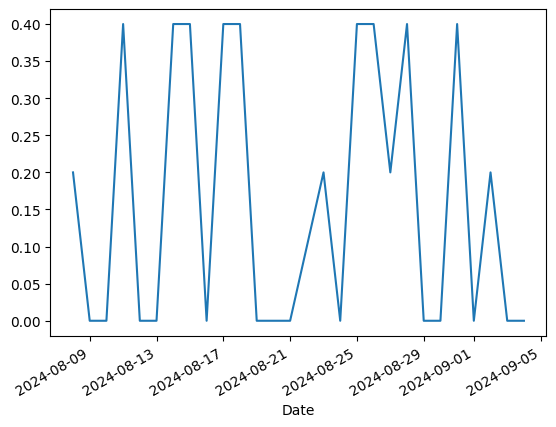

In [797]:
data.nausea.plot()

In [798]:
data['masturbation'] = (data.masturbate_before_sleep.astype('bool') | data.masturbate_time.astype('bool') | data.porn.astype('bool')).astype(float)

In [799]:
# Transfer randomized melatonin to other column
def update_melatonin(row):
    row['melatonin'] = row['melatonin'] if math.isnan(row['melatonin_randomized']) else row['melatonin_randomized'] * 0.15
    return row
# update melatonin data:
data = data.apply(lambda x: update_melatonin(x), axis=1)

### Autocorrelation

In [800]:
sessions.avg_energy.dropna()

Date
2024-05-30    84.833333
2024-06-01    79.625000
2024-06-02    77.500000
2024-06-03    69.777778
2024-06-07    76.857143
                ...    
2024-09-05    79.666667
2024-09-06    80.625000
2024-09-08    81.857143
2024-09-09    81.375000
2024-09-10    80.666667
Name: avg_energy, Length: 80, dtype: float64

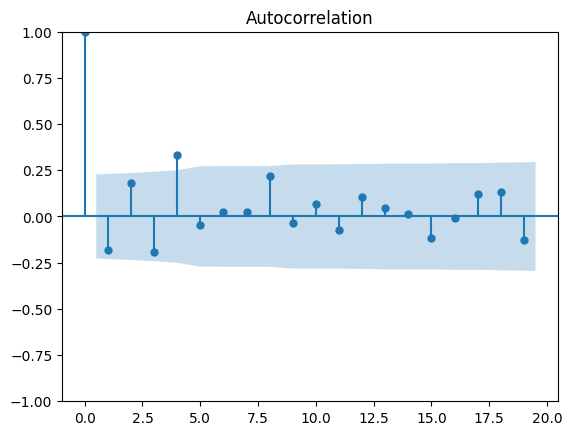

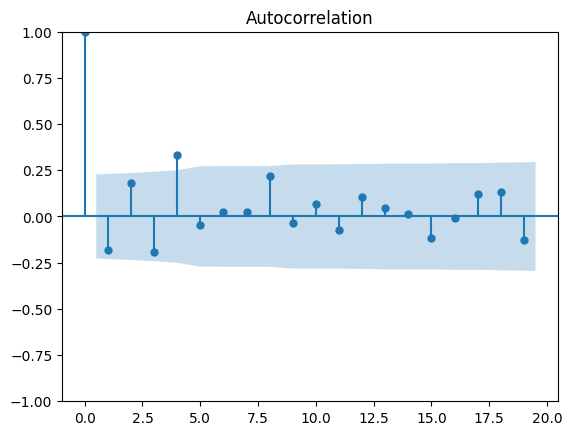

In [801]:
stg.tsaplots.plot_acf(data.session_1_1.dropna())

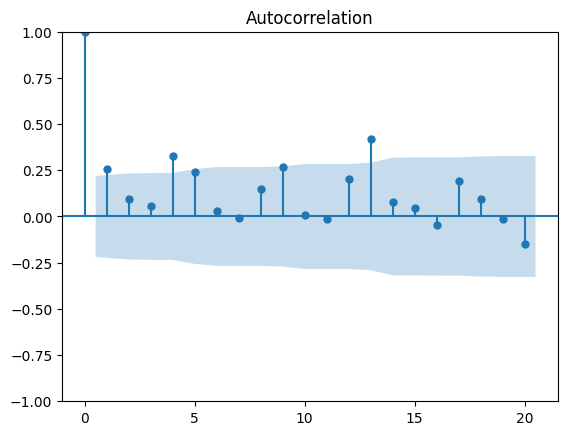

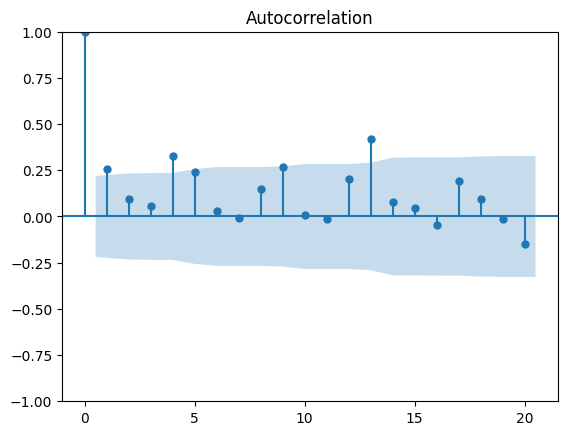

In [802]:
stg.tsaplots.plot_acf(sessions.avg_energy.dropna())

I am suprised to see essentially 0 autocorrelation in the first few days, but instead later down the line?

## Nausea Analysis

In [833]:
def analyse_nausea(data, column, shift=1):
    gluten = data.copy()
    gluten[column] = gluten[column].shift(periods=shift)
    gluten[column] = pd.to_numeric(gluten[column])

    gluten = gluten.dropna(subset=[column, 'nausea'])
    corr, p_value = pearsonr(gluten[column], gluten["nausea"])
    print(f"Pearson correlation between {column} shifted by {shift} days forward and nausea: {corr:.3f}")
    print(f"pvalue: {p_value:.3f}")
    print(f"sample size: {len(gluten)}")
        

In [834]:
for column in ["gluten", 'magnesium', 'potassium', 'iodine', 'omega3', 'vitamin_d', 'creatine_randomized', 'masturbation', 'masturbate_before_sleep', 'melatonin', 'melatonin_randomized', 'caffeine', 'porn']:
    for shift in [1,2]:
        analyse_nausea(data, column, shift=shift)


Pearson correlation between gluten shifted by 1 days forward and nausea: 0.079
pvalue: 0.701
sample size: 26
Pearson correlation between gluten shifted by 2 days forward and nausea: 0.248
pvalue: 0.233
sample size: 25
Pearson correlation between magnesium shifted by 1 days forward and nausea: 0.311
pvalue: 0.114
sample size: 27
Pearson correlation between magnesium shifted by 2 days forward and nausea: -0.266
pvalue: 0.181
sample size: 27
Pearson correlation between potassium shifted by 1 days forward and nausea: 0.058
pvalue: 0.774
sample size: 27
Pearson correlation between potassium shifted by 2 days forward and nausea: 0.214
pvalue: 0.283
sample size: 27
Pearson correlation between iodine shifted by 1 days forward and nausea: 0.101
pvalue: 0.617
sample size: 27
Pearson correlation between iodine shifted by 2 days forward and nausea: -0.458
pvalue: 0.016
sample size: 27
Pearson correlation between omega3 shifted by 1 days forward and nausea: 0.383
pvalue: 0.049
sample size: 27
Pears

/tmp/ipykernel_485007/3839827527.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(gluten[column], gluten["nausea"])


In [835]:
# Ensure that the date index is in numeric format for LOESS
df = sessions.copy()
df['date_numeric'] = df.index.map(pd.Timestamp.toordinal)

# Fit the LOESS model
loess_result = lowess(
    endog=df['avg_energy'],
    exog=df['date_numeric'],
    frac=0.1  # Adjust the fraction as needed for smoothing
)

# Convert the LOESS result into a DataFrame
loess_df = pd.DataFrame({
    'date_numeric': loess_result[:, 0],
    'avg_energy_trend': loess_result[:, 1]
})

# Map back to datetime

loess_df['date_numeric'] = loess_df['date_numeric'].map(int)
loess_df['date'] = loess_df['date_numeric'].map(pd.Timestamp.fromordinal)
loess_df.set_index('date_numeric', inplace=True)



<Axes: xlabel='Date'>

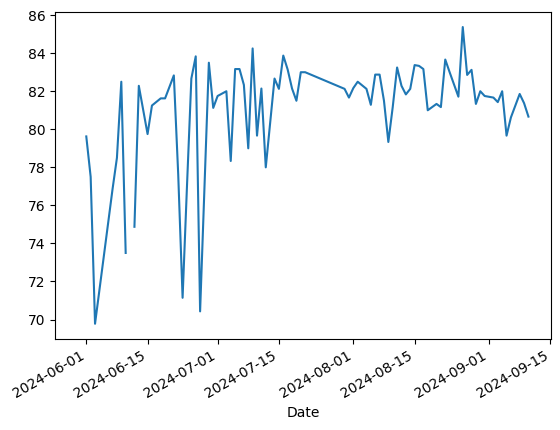

In [836]:
sessions.avg_energy.plot()

Trying to detrend the data to see if this influences the correlation between nausea and average energy (it basically didn't)

In [837]:
def analyze_nausea_energy_relationship(df, energy_col='avg_energy', nausea_col='nausea', frac=0.1):
    """
    Analyze the relationship between nausea and energy while accounting for trends in energy using LOESS.
    
    Parameters:
    - df: DataFrame indexed by date, containing energy and nausea columns.
    - energy_col: The column name for energy data (default 'avg_energy').
    - nausea_col: The column name for nausea data (default 'nausea').
    - frac: Fraction of data used for LOESS smoothing (default 0.1).
    
    Returns:
    - correlation: Pearson correlation between nausea and detrended energy.
    - regression_summary: Summary of the OLS regression between nausea and detrended energy.
    """
    
    # Ensure the date index is in numeric format for LOESS
    df['date_numeric'] = df.index.map(pd.Timestamp.toordinal)
    
    # Fit the LOESS model
    loess_result = lowess(endog=df[energy_col], exog=df['date_numeric'], frac=frac)
    
    # Convert the LOESS result into a DataFrame
    loess_df = pd.DataFrame({
        'date_numeric': loess_result[:, 0],
        'avg_energy_trend': loess_result[:, 1]
    })
    
    # Map back to datetime
    loess_df['date_numeric'] = loess_df['date_numeric'].map(int)
    loess_df['date'] = loess_df['date_numeric'].map(pd.Timestamp.fromordinal)
    loess_df.set_index('date', inplace=True)
    # loess_df.set_index('date_numeric', inplace=True)
    
    # Merge the LOESS trend back into the original DataFrame
    df = df.merge(loess_df['avg_energy_trend'], left_index=True, right_index=True, how='left')
    
    # Calculate the detrended 'avg_energy'
    df['avg_energy_detrended'] = df[energy_col] - df['avg_energy_trend']
    
    # Filter out rows where 'nausea' is NaN
    df_nausea = df.dropna(subset=[nausea_col, 'avg_energy_detrended'])
    
    # Compute the Pearson correlation coefficient
    correlation = df_nausea[nausea_col].corr(df_nausea['avg_energy_detrended'])
    
    # Perform OLS regression
    X = df_nausea['avg_energy_detrended']
    y = df_nausea[nausea_col]
    X = sm.add_constant(X)  # Add a constant for intercept
    model = sm.OLS(y, X).fit()
    
    # Plotting results (optional)
    plt.figure(figsize=(14, 10))
    
    # Plot original 'avg_energy' and LOESS trend
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df[energy_col], label='Original avg_energy')
    plt.plot(df.index, df['avg_energy_trend'], label='LOESS Trend', color='red')
    plt.title('Original avg_energy and LOESS Trend')
    plt.legend()
    
    # Plot detrended 'avg_energy'
    plt.subplot(3, 1, 2)
    plt.plot(df.index, df['avg_energy_detrended'], label='Detrended avg_energy', color='green')
    plt.title('Detrended avg_energy')
    plt.legend()
    
    # Plot 'nausea' episodes
    plt.subplot(3, 1, 3)
    plt.scatter(df_nausea.index, df_nausea[nausea_col], label='Nausea', color='orange')
    plt.title('Nausea Episodes')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Return the correlation and the regression summary
    return correlation, model.summary()

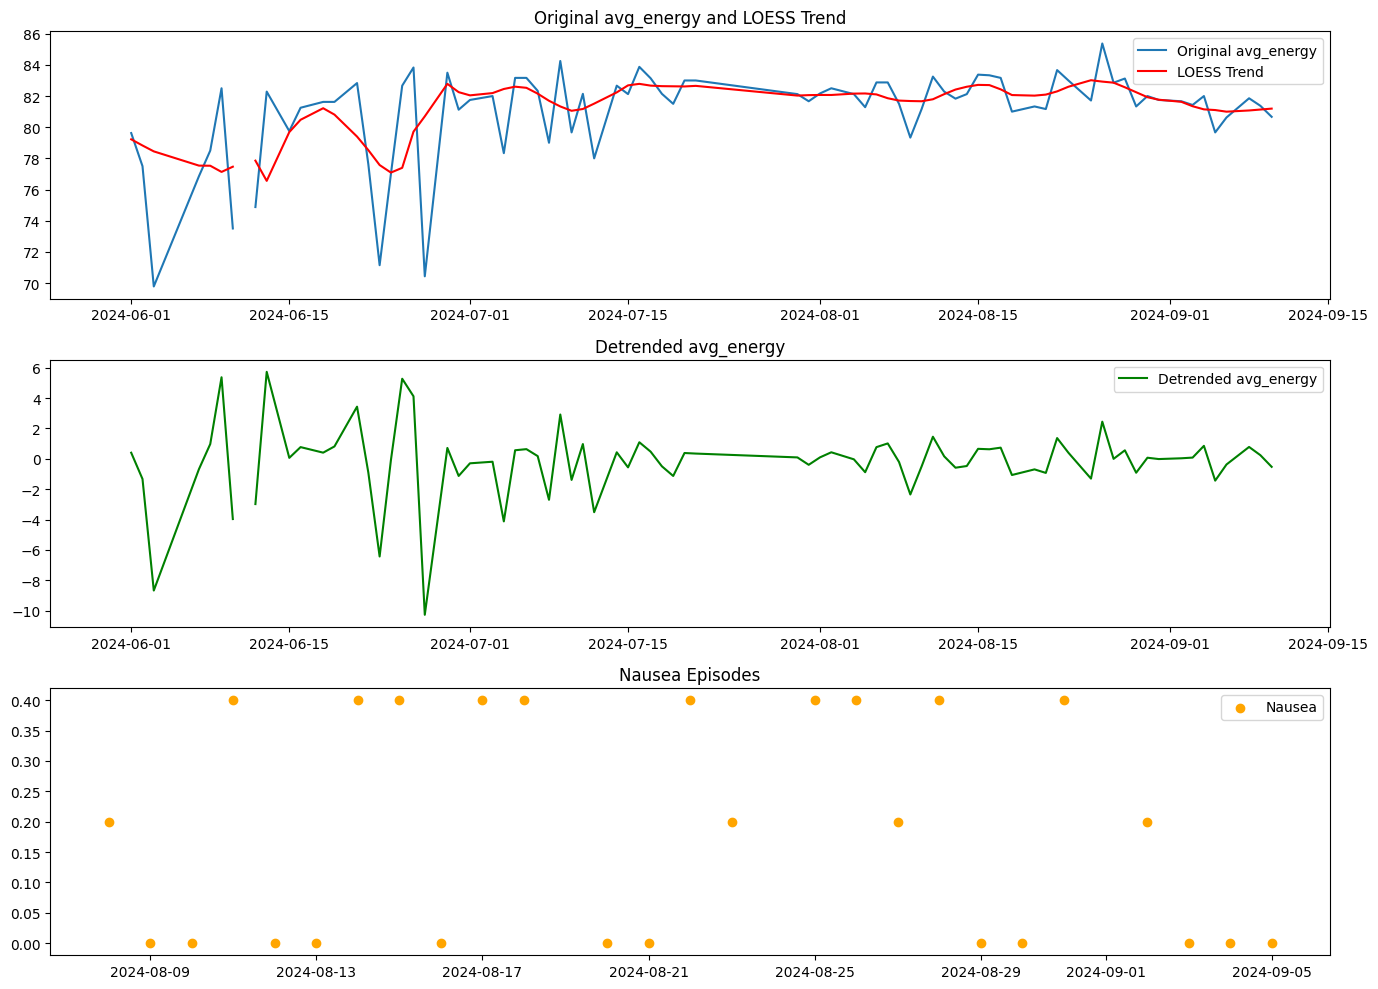

(0.4151795666074873,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                 nausea   R-squared:                       0.172
 Model:                            OLS   Adj. R-squared:                  0.138
 Method:                 Least Squares   F-statistic:                     4.999
 Date:                Sun, 06 Oct 2024   Prob (F-statistic):             0.0349
 Time:                        13:18:21   Log-Likelihood:                 9.6754
 No. Observations:                  26   AIC:                            -15.35
 Df Residuals:                      24   BIC:                            -12.83
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
 --------------------------------------

In [838]:
analyze_nausea_energy_relationship(sessions, energy_col='avg_energy', nausea_col='nausea', frac=0.1)

# Results

Pearson correlation between nausea shifted by 0 days forward and average energy levels: 0.478
P-value: 0.018
Sample size: 24


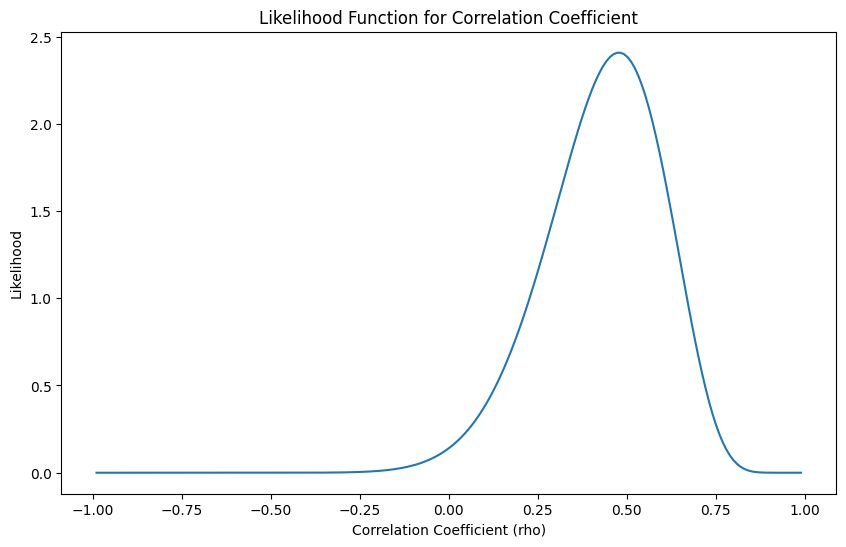

Pearson correlation between nausea shifted by 1 days forward and average energy levels: 0.079
P-value: 0.721
Sample size: 23


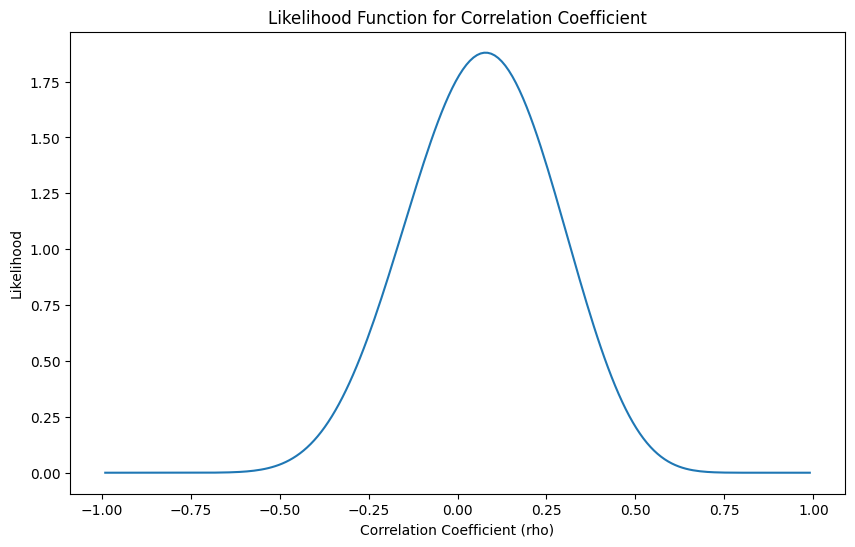

Pearson correlation between sleep_duration shifted by 0 days forward and average energy levels: -0.031
P-value: 0.794
Sample size: 74


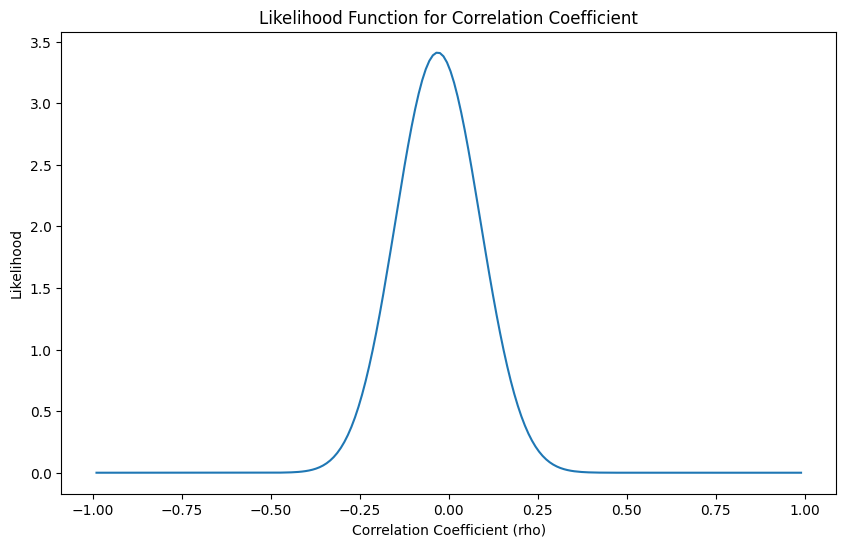

Pearson correlation between sleep_duration shifted by 1 days forward and average energy levels: 0.082
P-value: 0.492
Sample size: 73


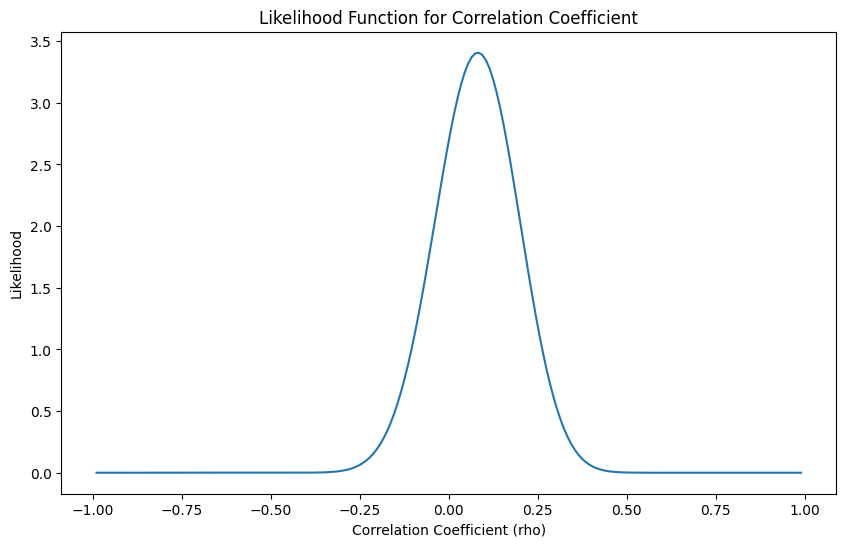

Pearson correlation between potassium shifted by 0 days forward and average energy levels: -0.028
P-value: 0.877
Sample size: 32


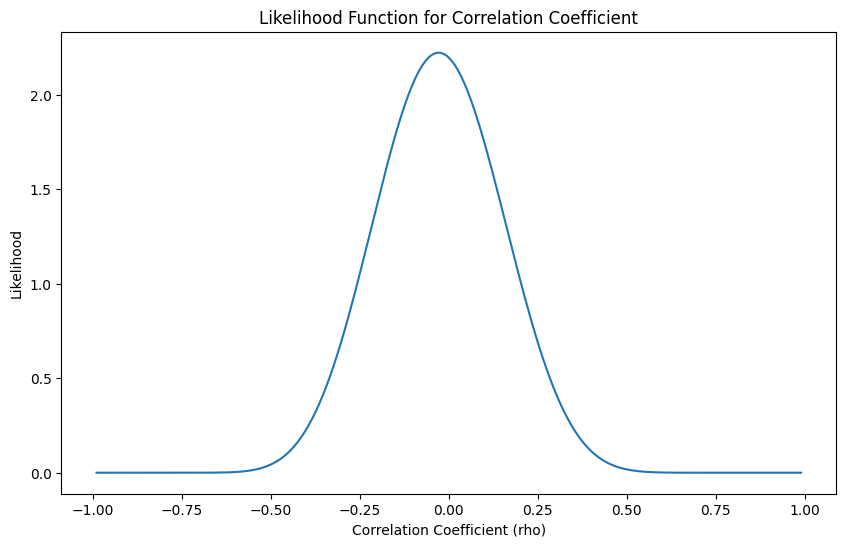

Pearson correlation between potassium shifted by 1 days forward and average energy levels: -0.181
P-value: 0.329
Sample size: 31


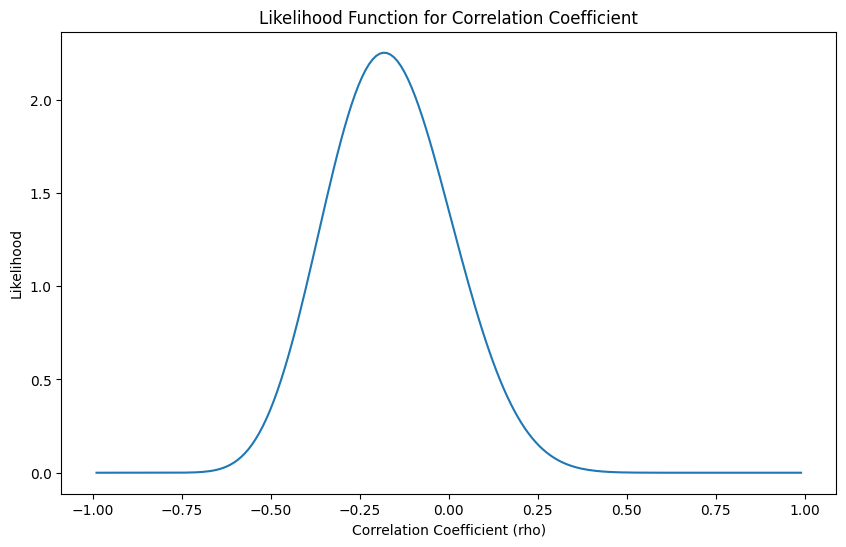

Pearson correlation between magnesium shifted by 0 days forward and average energy levels: 0.070
P-value: 0.712
Sample size: 30


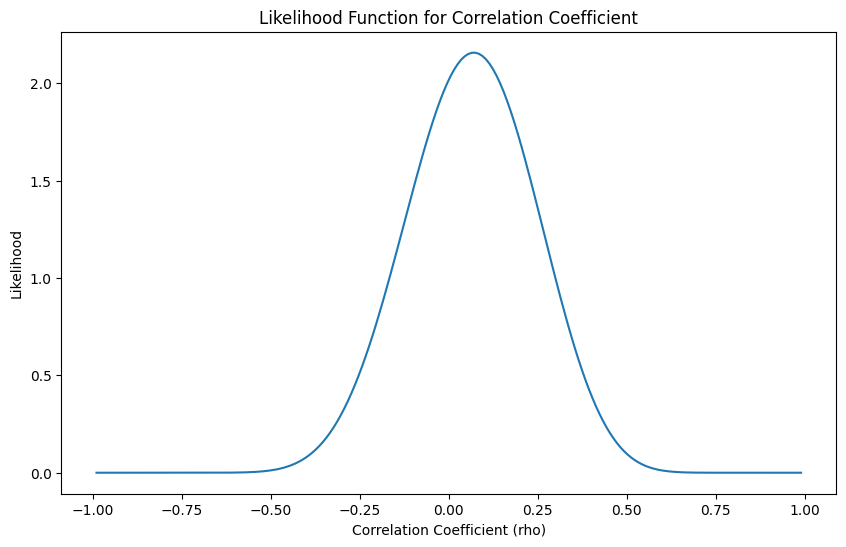

Pearson correlation between magnesium shifted by 1 days forward and average energy levels: 0.186
P-value: 0.334
Sample size: 29


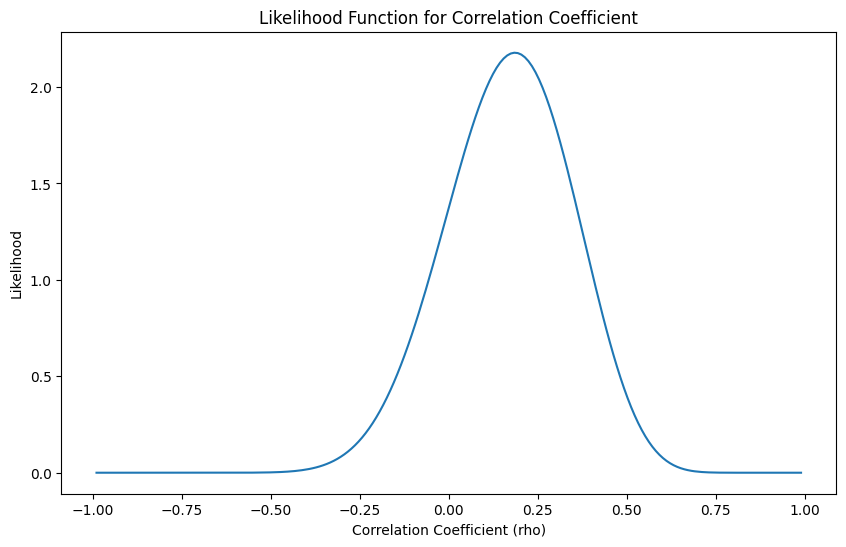

Pearson correlation between iodine shifted by 0 days forward and average energy levels: 0.013
P-value: 0.913
Sample size: 74


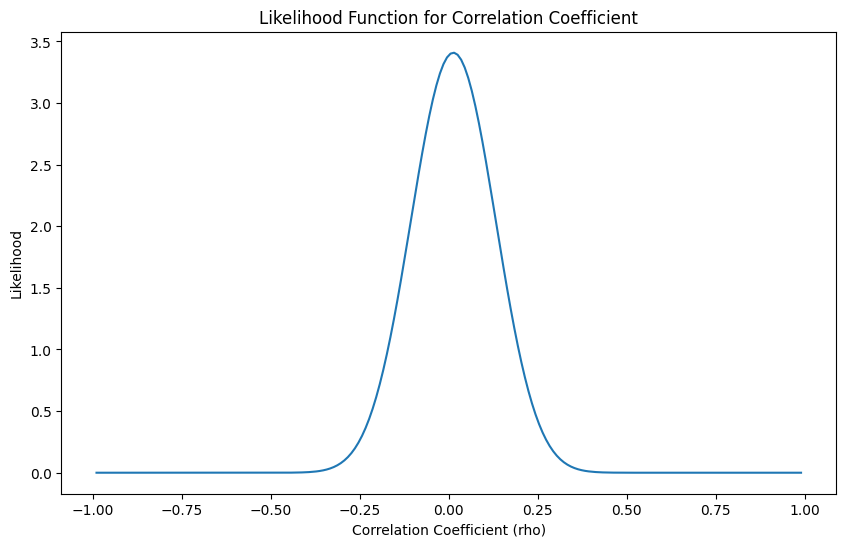

Pearson correlation between iodine shifted by 1 days forward and average energy levels: -0.089
P-value: 0.452
Sample size: 73


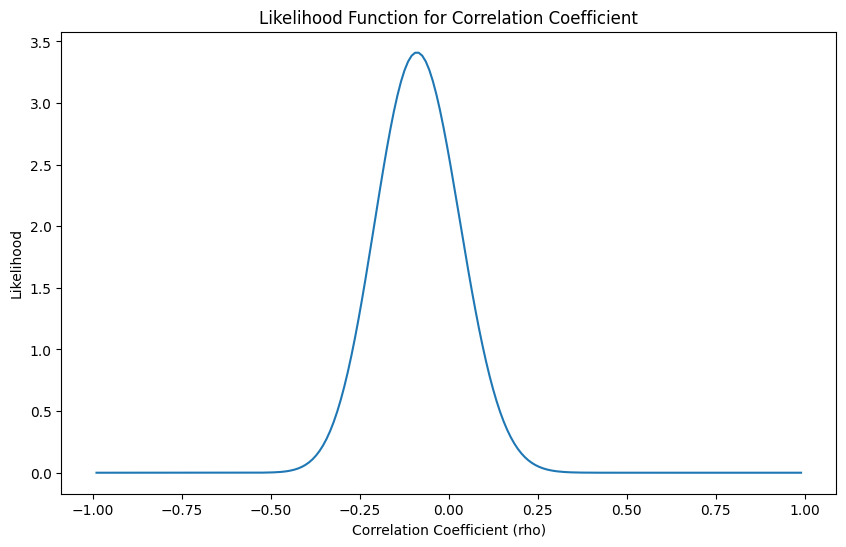

Pearson correlation between omega3 shifted by 0 days forward and average energy levels: -0.032
P-value: 0.796
Sample size: 68


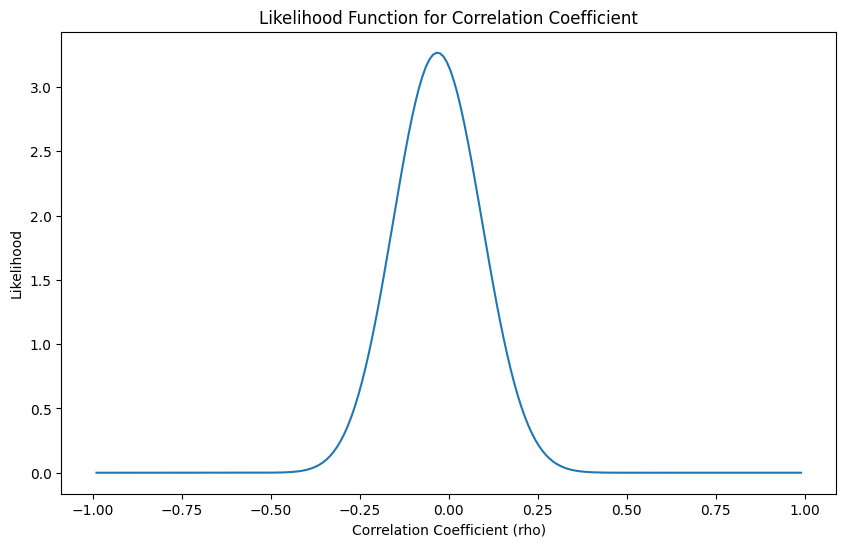

Pearson correlation between omega3 shifted by 1 days forward and average energy levels: -0.217
P-value: 0.078
Sample size: 67


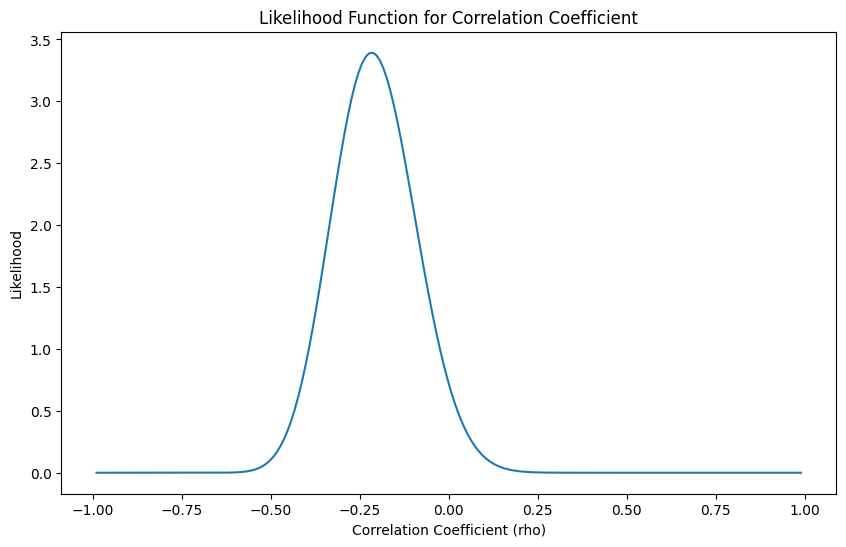

Pearson correlation between vitamin_d shifted by 0 days forward and average energy levels: 0.012
P-value: 0.921
Sample size: 68


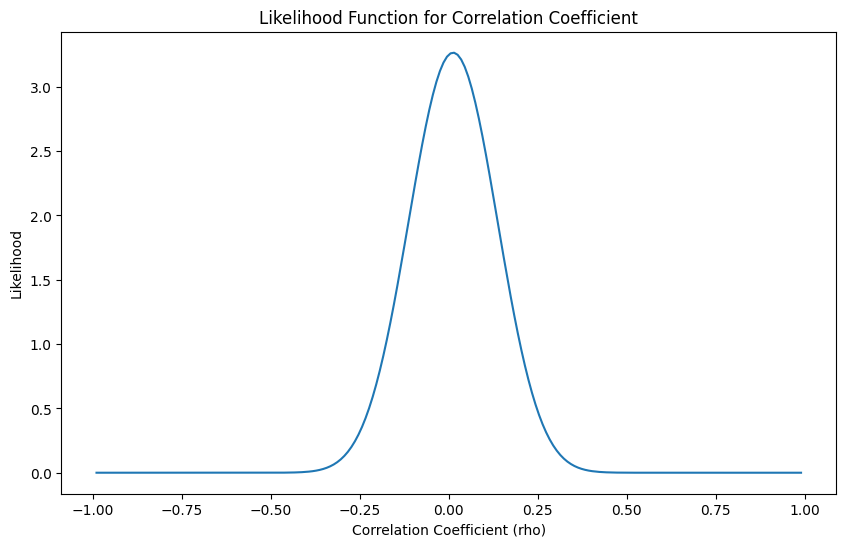

Pearson correlation between vitamin_d shifted by 1 days forward and average energy levels: -0.243
P-value: 0.048
Sample size: 67


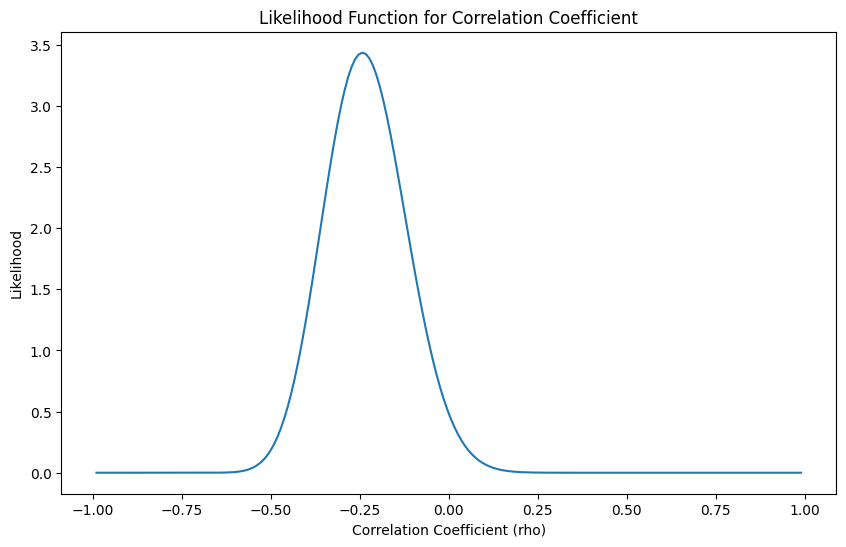

Pearson correlation between creatine_randomized shifted by 0 days forward and average energy levels: -0.027
P-value: 0.902
Sample size: 23


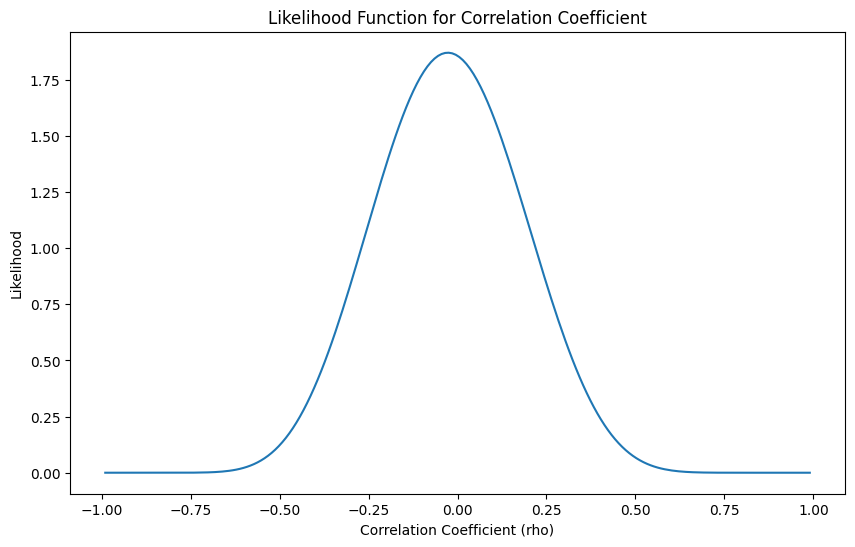

Pearson correlation between creatine_randomized shifted by 1 days forward and average energy levels: -0.177
P-value: 0.430
Sample size: 22


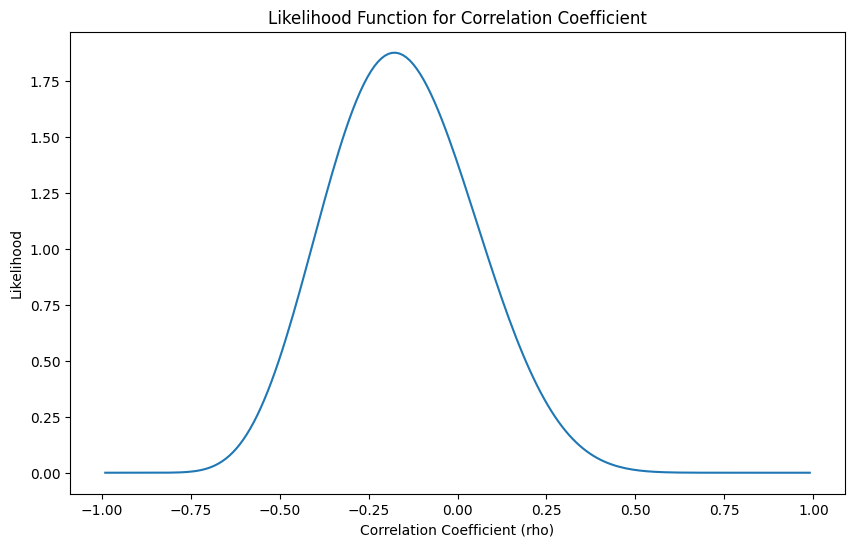

Pearson correlation between masturbation shifted by 0 days forward and average energy levels: -0.171
P-value: 0.145
Sample size: 74


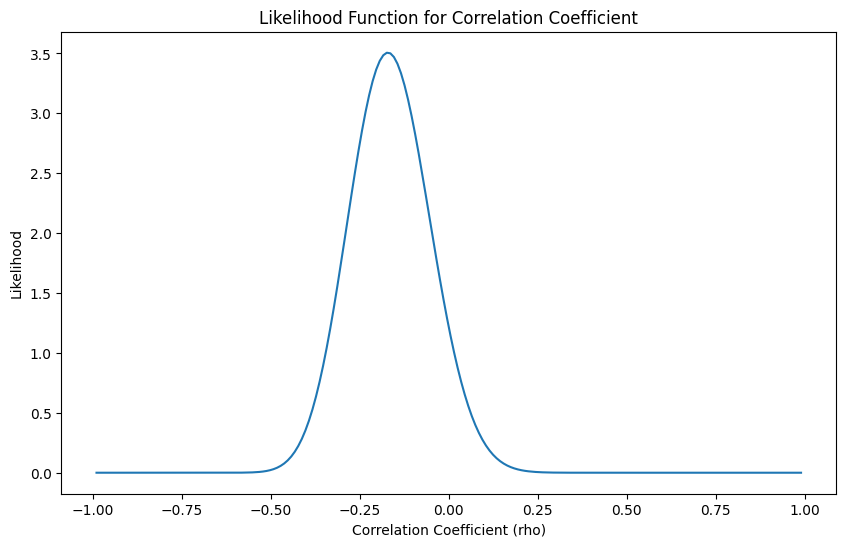

Pearson correlation between masturbation shifted by 1 days forward and average energy levels: -0.174
P-value: 0.141
Sample size: 73


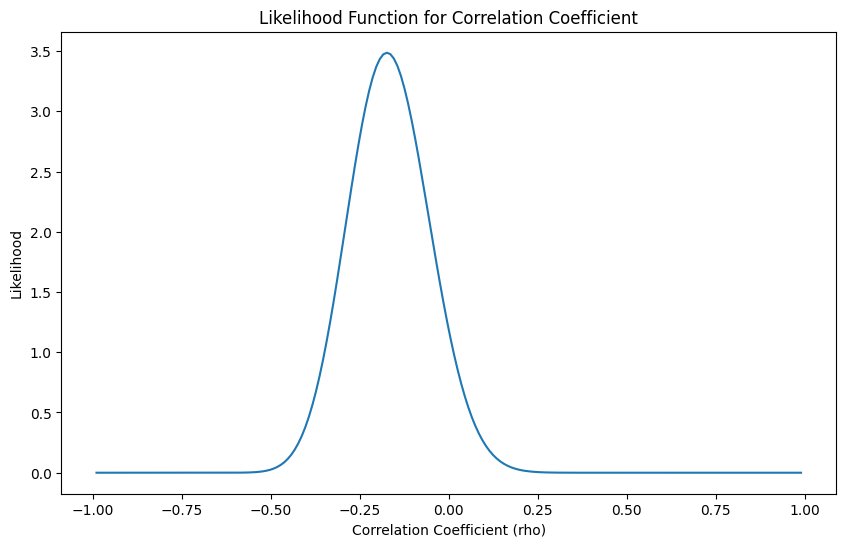

Pearson correlation between masturbate_before_sleep shifted by 0 days forward and average energy levels: -0.315
P-value: 0.006
Sample size: 74


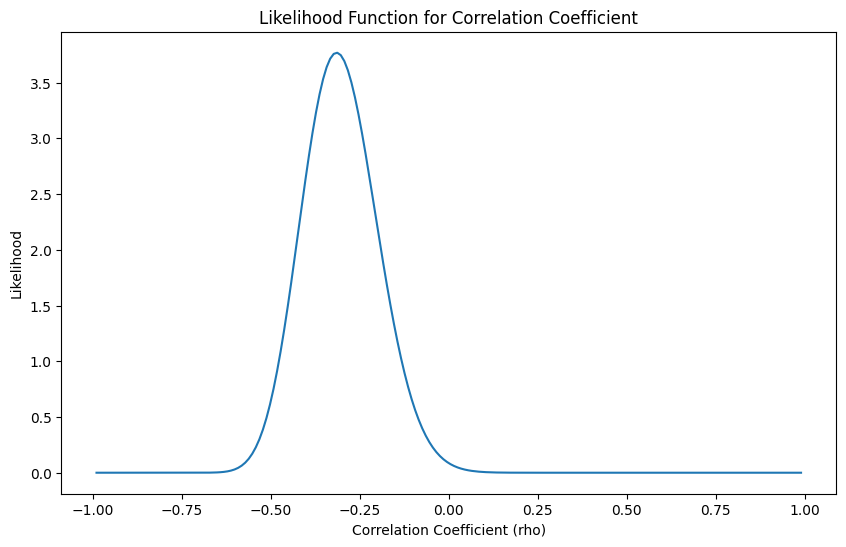

Pearson correlation between masturbate_before_sleep shifted by 1 days forward and average energy levels: -0.180
P-value: 0.127
Sample size: 73


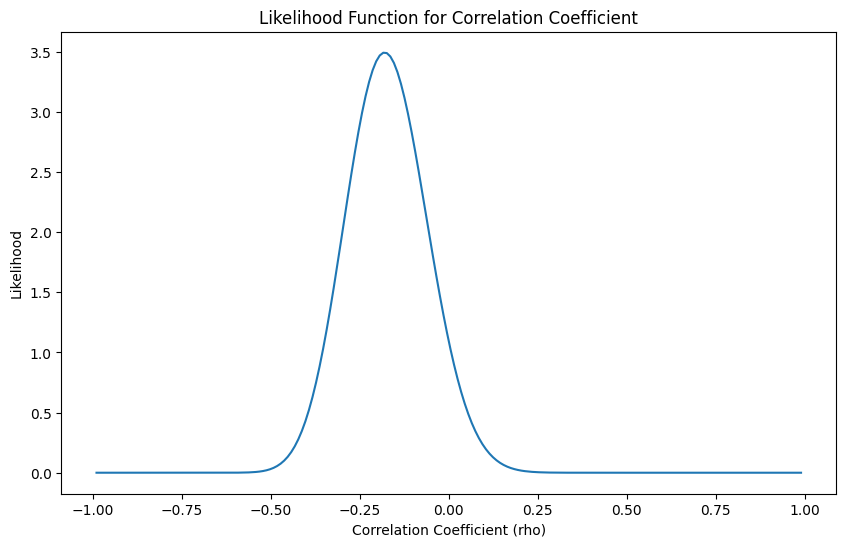

Pearson correlation between melatonin shifted by 0 days forward and average energy levels: -0.035
P-value: 0.770
Sample size: 74


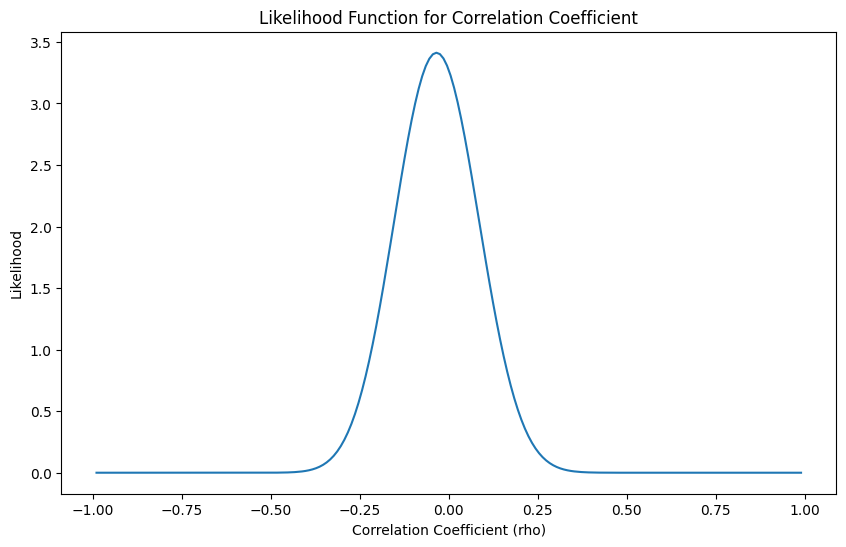

Pearson correlation between melatonin shifted by 1 days forward and average energy levels: 0.126
P-value: 0.286
Sample size: 73


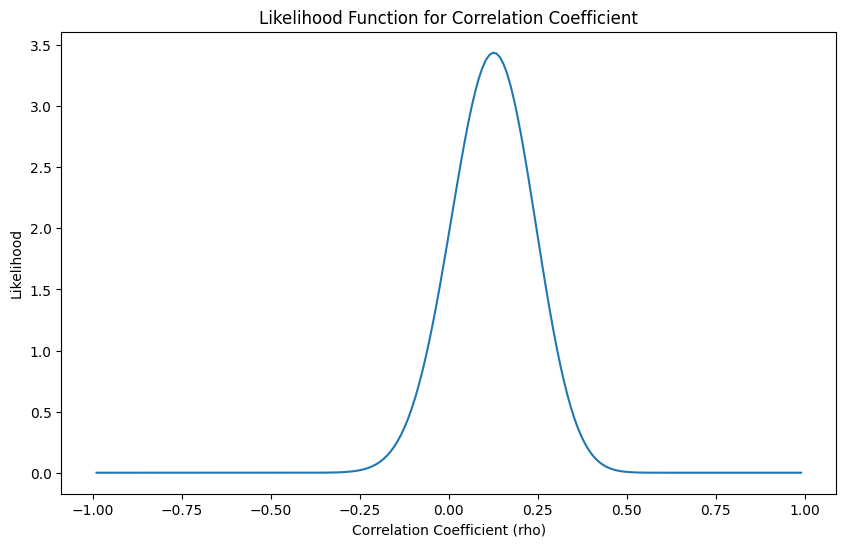

Pearson correlation between melatonin_randomized shifted by 0 days forward and average energy levels: -0.249
P-value: 0.251
Sample size: 23


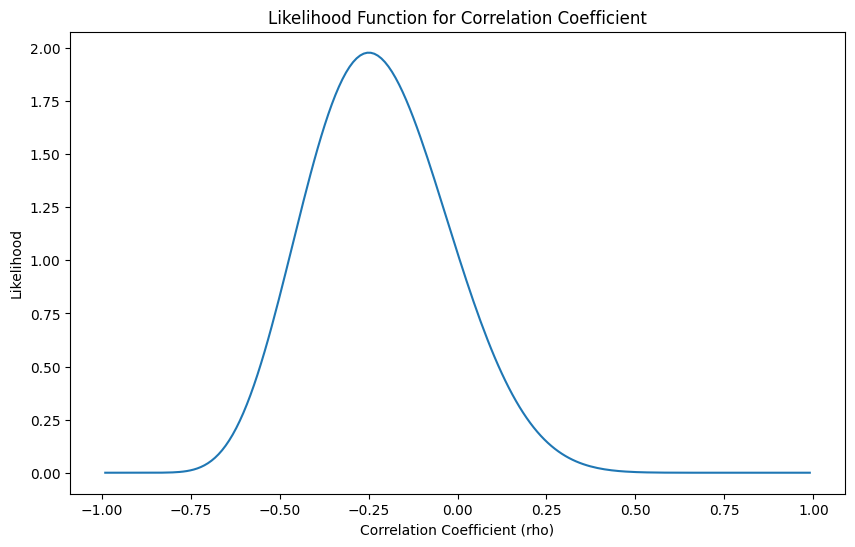

Pearson correlation between melatonin_randomized shifted by 1 days forward and average energy levels: -0.267
P-value: 0.230
Sample size: 22


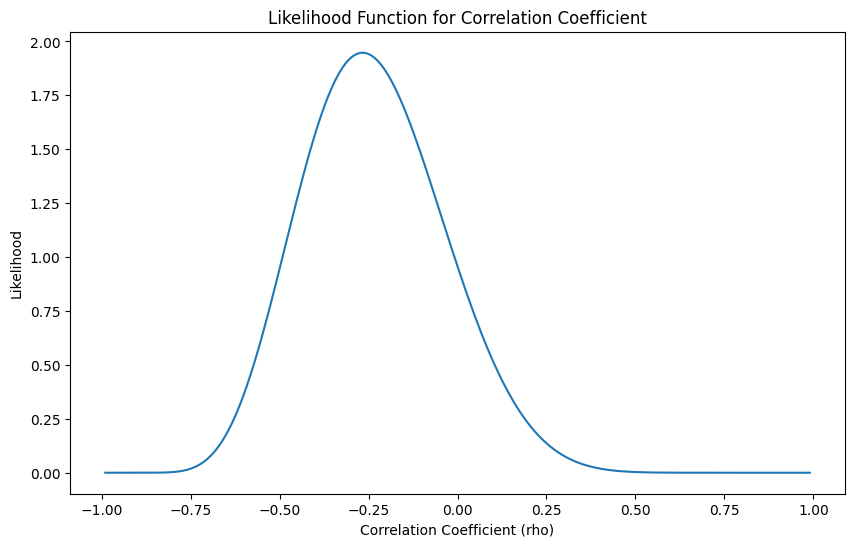

Pearson correlation between caffeine shifted by 0 days forward and average energy levels: -0.081
P-value: 0.492
Sample size: 74


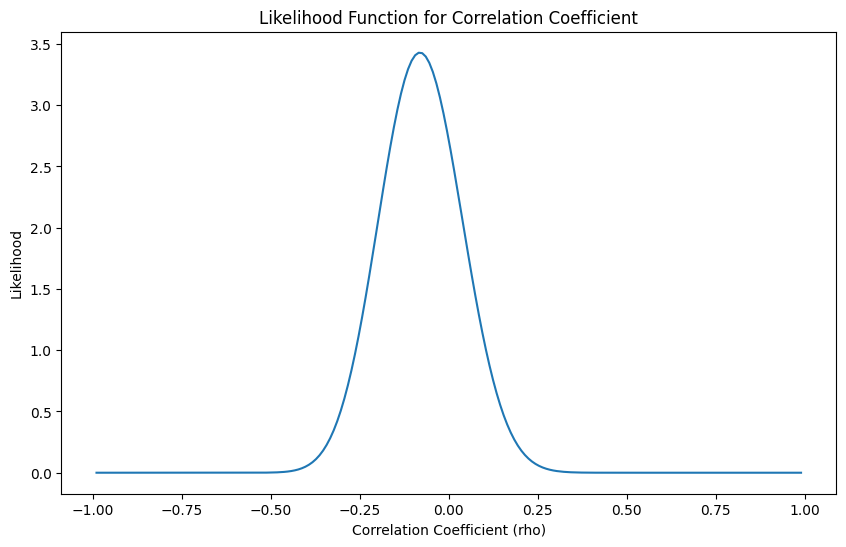

Pearson correlation between caffeine shifted by 1 days forward and average energy levels: -0.207
P-value: 0.079
Sample size: 73


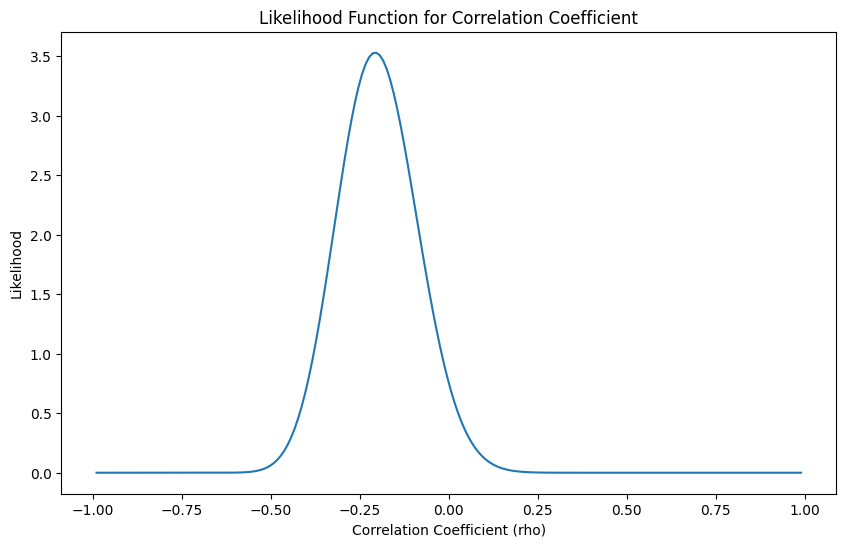

Pearson correlation between porn shifted by 0 days forward and average energy levels: -0.105
P-value: 0.372
Sample size: 74


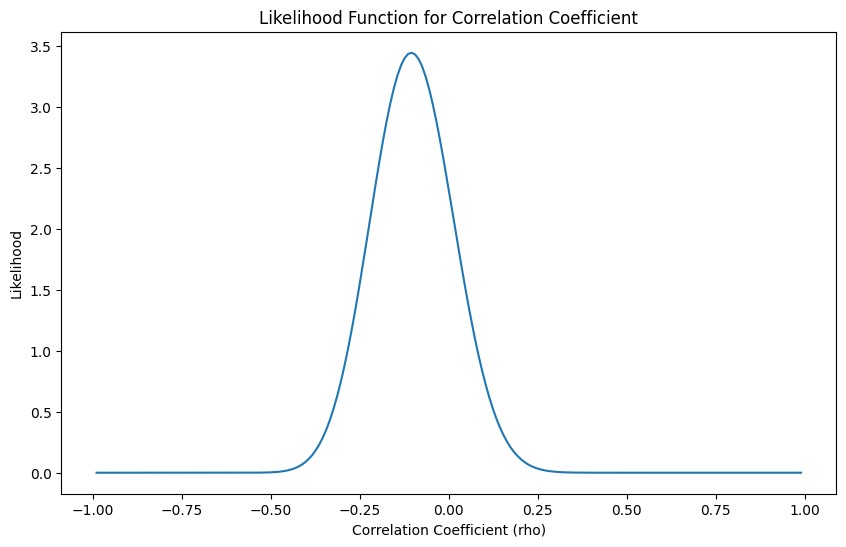

Pearson correlation between porn shifted by 1 days forward and average energy levels: -0.246
P-value: 0.036
Sample size: 73


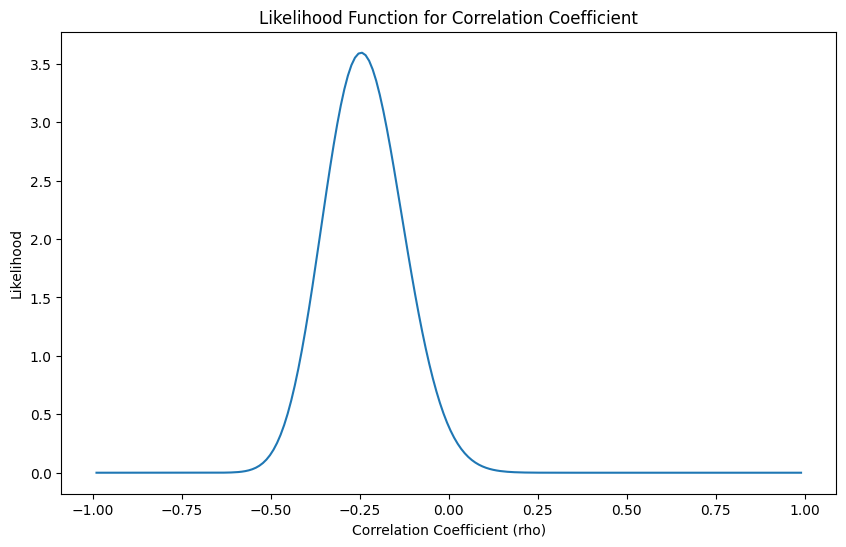

In [841]:
upstream_vars = ['nausea', 'sleep_duration', 'potassium', 'magnesium', 'iodine', 'omega3', 'vitamin_d', 'creatine_randomized', 'masturbation', 'masturbate_before_sleep', 'melatonin', 'melatonin_randomized', 'caffeine', 'porn']
for column in upstream_vars: # NOTE: 'time in bed' was apparently a column, but it is gone now'
    start = '2024-05-29'
    end = '2024-09-10'
    if column == 'potassium':
        start = '2024-07-29' # changed randomization frequency here
    if column == 'omega3' or column == 'vitamin_d':
        start = '2024-06-9' # changed randomization here
    if column == 'creatine_randomized' or column == 'melatonin_randomized':
        start = '2024-08-09' # started to randomize these
    analyze_energy_levels_correlation_with_likelihood(data, start, end, column, shift_days=0)
    analyze_energy_levels_correlation_with_likelihood(data, start, end, column, shift_days=1)

In [842]:
for column in upstream_vars: # NOTE: 'time in bed' was apparently a column, but it is gone now'
    start = '2024-05-29'
    end = '2024-09-10'
    if column == 'potassium':
        start = '2024-07-29' # changed randomization frequency here
    if column == 'omega3' or column == 'vitamin_d':
        start = '2024-06-9' # changed randomization here
    if column == 'creatine_randomized' or column == 'melatonin_randomized':
        start = '2024-08-09' # started to randomize these
    analyze_energy_levels_correlation_with_likelihood(data, start, end, column, shift_days=0, plotting=False)
    analyze_energy_levels_correlation_with_likelihood(data, start, end, column, shift_days=1, plotting=False)

Pearson correlation between nausea shifted by 0 days forward and average energy levels: 0.478
P-value: 0.018
Sample size: 24
Pearson correlation between nausea shifted by 1 days forward and average energy levels: 0.079
P-value: 0.721
Sample size: 23
Pearson correlation between sleep_duration shifted by 0 days forward and average energy levels: -0.031
P-value: 0.794
Sample size: 74
Pearson correlation between sleep_duration shifted by 1 days forward and average energy levels: 0.082
P-value: 0.492
Sample size: 73
Pearson correlation between potassium shifted by 0 days forward and average energy levels: -0.028
P-value: 0.877
Sample size: 32
Pearson correlation between potassium shifted by 1 days forward and average energy levels: -0.181
P-value: 0.329
Sample size: 31
Pearson correlation between magnesium shifted by 0 days forward and average energy levels: 0.070
P-value: 0.712
Sample size: 30
Pearson correlation between magnesium shifted by 1 days forward and average energy levels: 0.186


In [843]:
data['standup_delta']= data['standup'].apply(lambda x: (x - datetime.datetime(1900,1,1)).total_seconds()/60.0)
data['woke_up_delta']= data['woke_up'].apply(lambda x: (x - datetime.datetime(1900,1,1)).total_seconds()/ 60.0)

<Axes: >

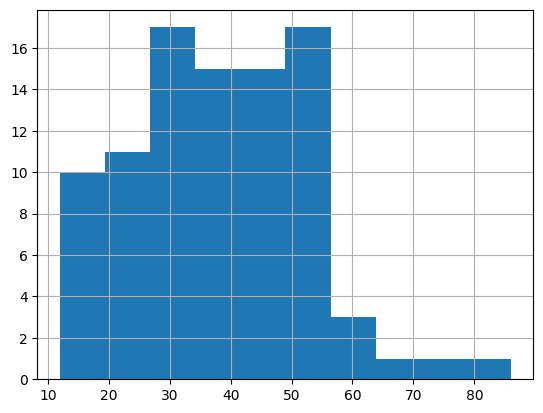

In [844]:
data['time_to_fall_asleep'].hist()

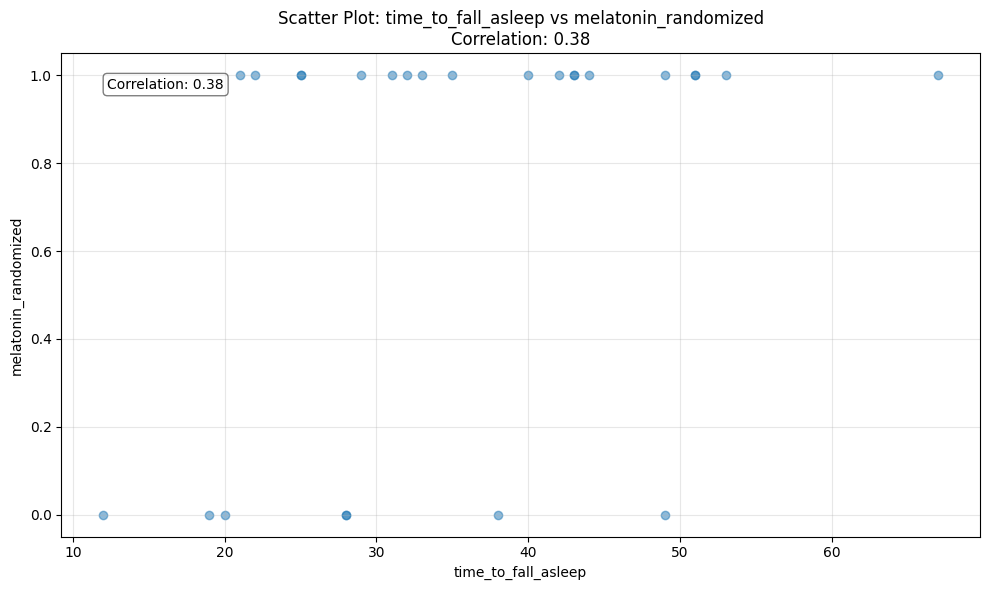

In [845]:
plot_scatter_with_correlation(data, 'time_to_fall_asleep', 'melatonin_randomized')

In [846]:
sleep_upstream_vars = ['melatonin_randomized', 'magnesium']
sleep_downstream_vars = ['sleep_duration', 'time_in_bed', 'standup_delta', 'woke_up_delta', 'time_to_fall_asleep']
# 'woke_up', 'standup'
for column in sleep_upstream_vars:
    for sleep_column in sleep_downstream_vars:
        start = '2024-05-29'
        end = '2024-09-10'
        if column == 'potassium':
            start = '2024-07-29' # changed randomization frequency here
        if column == 'omega3' or column == 'vitamin_d':
            start = '2024-06-9' # changed randomization here
        if column == 'creatine_randomized' or column == 'melatonin_randomized':
            start = '2024-08-09' # started to randomize these
        shift = 0
        analyze_sleep_data(data, start, end, column, sleep_score_column=sleep_column, shift_days=shift)

Pearson correlation between melatonin_randomized shifted by 0 days forward and sleep_duration: -0.197
P-value: 0.336
Sample size: 26
Pearson correlation between melatonin_randomized shifted by 0 days forward and time_in_bed: -0.137
P-value: 0.505
Sample size: 26
Pearson correlation between melatonin_randomized shifted by 0 days forward and standup_delta: 0.027
P-value: 0.896
Sample size: 26
Pearson correlation between melatonin_randomized shifted by 0 days forward and woke_up_delta: 0.060
P-value: 0.770
Sample size: 26
Pearson correlation between melatonin_randomized shifted by 0 days forward and time_to_fall_asleep: 0.382
P-value: 0.054
Sample size: 26
Pearson correlation between magnesium shifted by 0 days forward and sleep_duration: 0.127
P-value: 0.474
Sample size: 34
Pearson correlation between magnesium shifted by 0 days forward and time_in_bed: 0.100
P-value: 0.573
Sample size: 34
Pearson correlation between magnesium shifted by 0 days forward and standup_delta: 0.065
P-value: 0

## Potassium

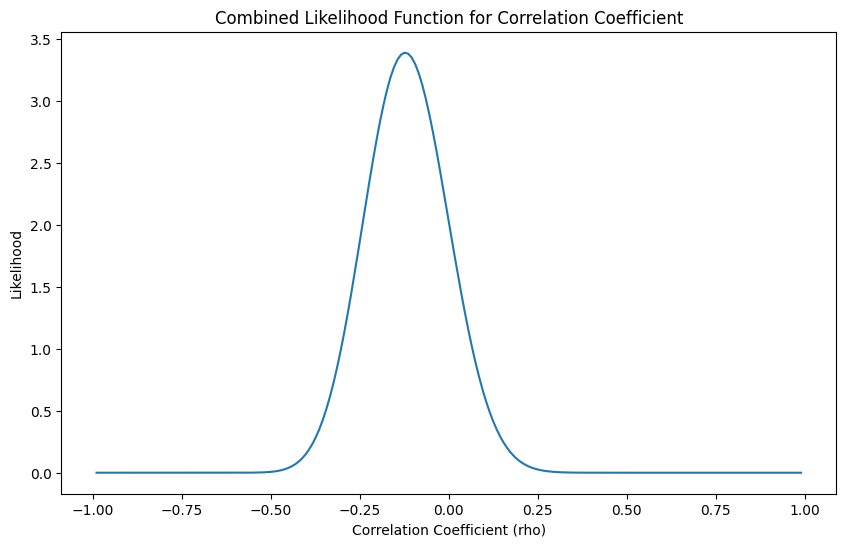

Combined correlation coefficient: -0.122 for potassium shifted by 0 days and average energy levels
Combined p-value: 0.310
95% Confidence interval: (-0.346, 0.114)
Combined sample size: 74


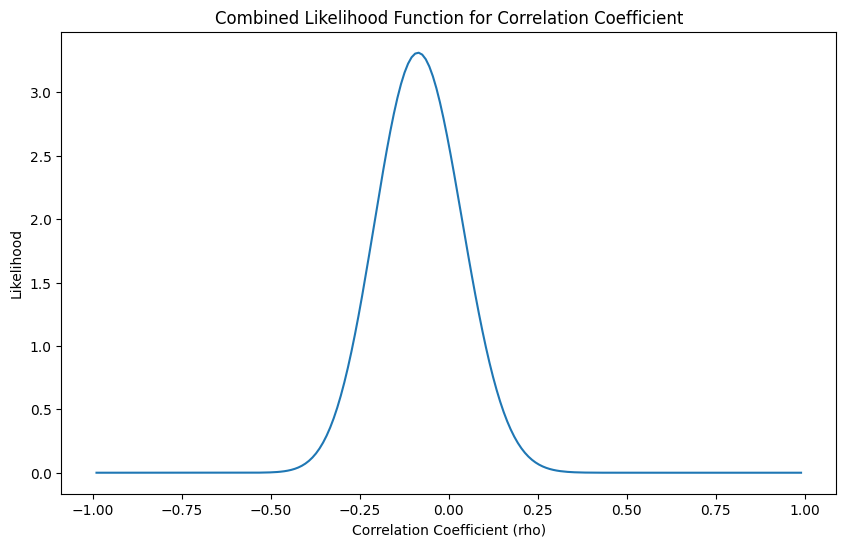

Combined correlation coefficient: -0.086 for potassium shifted by 1 days and average energy levels
Combined p-value: 0.482
95% Confidence interval: (-0.317, 0.153)
Combined sample size: 72


In [691]:
# Define your data (assuming 'data' is your DataFrame)
# data = pd.read_csv('your_data.csv', parse_dates=True, index_col='date')

for shift_days in [0, 1]:
    # Define the column and shift_days
    column = 'potassium'
    # Define the date ranges for each trial
    # Trial 1: 2024-05-25 to 2024-07-21
    start_date1 = '2024-05-25'
    end_date1 = '2024-07-21'

    # Trial 2: 2024-07-29 to 2024-09-10 (as per your code)
    start_date2 = '2024-07-29'
    end_date2 = '2024-09-10'

    with open(os.devnull, 'w') as devnull:
        with redirect_stdout(devnull):
            # Analyze Trial 1
            result1 = analyze_energy_levels_correlation_with_likelihood(
                data, start_date1, end_date1, column, shift_days=shift_days, plotting=False)

            # Analyze Trial 2
            result2 = analyze_energy_levels_correlation_with_likelihood(
                data, start_date2, end_date2, column, shift_days=shift_days, plotting=False)

    # Combine the results
    combined_result = combine_trial_results(result1, result2, plotting=True)

    # Print the combined results
    print(f"Combined correlation coefficient: {combined_result['r_combined']:.3f} for {column} shifted by {shift_days} days and average energy levels")
    print(f"Combined p-value: {combined_result['p_value_combined']:.3f}")
    print(f"95% Confidence interval: ({combined_result['confidence_interval'][0]:.3f}, {combined_result['confidence_interval'][1]:.3f})")
    print(f"Combined sample size: {combined_result['n_combined']}")


In [692]:
for sleep_column in sleep_downstream_vars:
    for shift_days in [0, 1]:
        # Define your data (assuming 'data' is your DataFrame)
        # data = pd.read_csv('your_data.csv', parse_dates=True, index_col='date')

        # Define the column and shift_days
        column = 'potassium'

        # Define the date ranges for each trial
        # Trial 1: 2024-05-25 to 2024-07-21
        start_date1 = '2024-05-25'
        end_date1 = '2024-07-21'

        # Trial 2: 2024-07-29 to 2024-09-10 (as per your code)
        start_date2 = '2024-07-29'
        end_date2 = '2024-09-10'


        # Suppress print output in a Jupyter notebook
        with open(os.devnull, 'w') as devnull:
            with redirect_stdout(devnull):
                # Analyze Trial 1
                result1 = analyze_sleep_data(
                    data, start_date1, end_date1, column, shift_days=shift_days, plotting=False, sleep_score_column=sleep_column)

                # Analyze Trial 2
                result2 = analyze_sleep_data(
                    data, start_date2, end_date2, column, shift_days=shift_days, plotting=False, sleep_score_column=sleep_column)

        # Combine the results
        combined_result = combine_trial_results(result1, result2, plotting=False)

        # Print the combined results
        print(f"Combined correlation coefficient: {combined_result['r_combined']:.3f} for {sleep_column} and {column} shifted by {shift_days} days")
        print(f"Combined p-value: {combined_result['p_value_combined']:.3f}")
        print(f"95% Confidence interval: ({combined_result['confidence_interval'][0]:.3f}, {combined_result['confidence_interval'][1]:.3f})")
        print(f"Combined sample size: {combined_result['n_combined']}")


Combined correlation coefficient: 0.065 for sleep_duration and potassium shifted by 0 days
Combined p-value: 0.553
95% Confidence interval: (-0.149, 0.273)
Combined sample size: 89
Combined correlation coefficient: -0.149 for sleep_duration and potassium shifted by 1 days
Combined p-value: 0.176
95% Confidence interval: (-0.352, 0.067)
Combined sample size: 87
Combined correlation coefficient: -0.226 for time_in_bed and potassium shifted by 0 days
Combined p-value: 0.036
95% Confidence interval: (-0.418, -0.015)
Combined sample size: 89
Combined correlation coefficient: -0.151 for time_in_bed and potassium shifted by 1 days
Combined p-value: 0.170
95% Confidence interval: (-0.354, 0.065)
Combined sample size: 87
Combined correlation coefficient: -0.201 for standup_delta and potassium shifted by 0 days
Combined p-value: 0.063
95% Confidence interval: (-0.396, 0.011)
Combined sample size: 89
Combined correlation coefficient: 0.052 for standup_delta and potassium shifted by 1 days
Combine

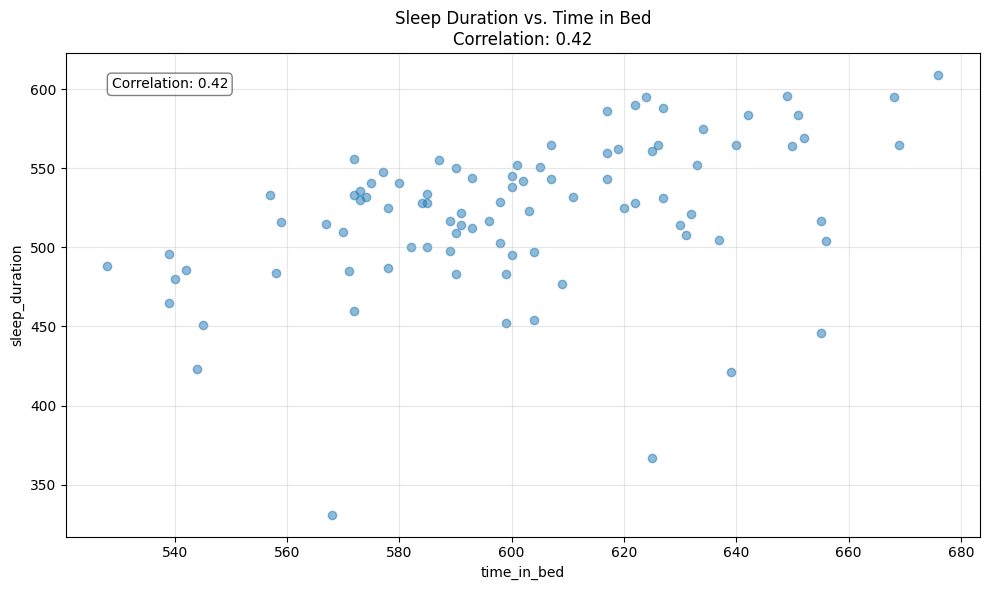

In [693]:
plot_scatter_with_correlation(data, 'time_in_bed', 'sleep_duration', title='Sleep Duration vs. Time in Bed')

# Analysis of sun on work (deprecated)

In [39]:
sun_hours = pd.read_csv("data/weather/estimated_daily_sun_hours.csv")
sun_hours['Date'] = pd.to_datetime(sun_hours['Date'])
sun_hours.index=sun_hours['Date']
sun_hours.rename(columns={"Total Estimated Sun Hours": "sun_hours"}, inplace=True)

In [40]:

sun_hours_during_work = pd.read_csv("data/weather/estimated_daily_sun_hours_during_work.csv")
sun_hours_during_work['Date'] = pd.to_datetime(sun_hours_during_work['Date'])
sun_hours_during_work.index=sun_hours_during_work['Date']
sun_hours_during_work.rename(columns={"Total Estimated Sun Hours": "sun_work_hours"}, inplace=True)

In [41]:
sun_hours_during_work

,Date,sun_work_hours
Date,,
2024-05-01,2024-05-01,0.00
2024-05-02,2024-05-02,0.45
2024-05-03,2024-05-03,0.00
2024-05-04,2024-05-04,3.04
2024-05-05,2024-05-05,2.93
...,...,...
2024-09-19,2024-09-19,1.03
2024-09-20,2024-09-20,3.56
2024-09-21,2024-09-21,1.67


In [42]:

work_days_1 = filtered_data.join(sun_hours)[filtered_data.rest_day==0]
work_days = work_days_1.join(sun_hours_during_work['sun_work_hours'])

session_names = ['session_1_2', 'session_1_3', 'session_2_1', 'session_2_2', 'session_2_3']
work_days['work']  = work_days['session_1_1']

for session_name in session_names:
    work_days['work'] += work_days[session_name]
work_days['work'] = work_days['work'] / 6
work_days = work_days.dropna(subset=['work'])

In [43]:
df = pd.DataFrame()

In [ ]:
plot_scatter_with_correlation(data)

In [228]:
work_days.columns

Index(['date', 'went_to_bed', 'fell_asleep', 'in_bed_for', 'woke_up',
       'standup', 'weekday', 'potassium', 'iodine', 'omega3', 'vitamin_d',
       'vitamin_b', 'magnesium', 'probiotic', 'notes', 'creatine',
       'masturbate', 'masturbate', 'porn', 'earplugs', 'window', 'melatonin',
       'Übelkeit', 'last_food', 'l_theanine', 'methylphenidate',
       'muntermacher', 'caffeine', 'Unnamed: 28', 'session_1_cold_shower',
       'session_2_cold_shower', 'session_3', 'rest_day', 'session_1_1',
       'session_1_2', 'session_1_3', 'session_2_1', 'session_2_2',
       'session_2_3', 'session_3_1', 'session_3_2', 'session_3_3',
       'avg_energy_session_1', 'avg_energy_session_2', 'avg_energy', 'Date',
       'sun_hours', 'sun_work_hours', 'work'],
      dtype='object')

In [427]:
plot_scatter_with_correlation(work_days, 'work', 'sun_hours')

NameError: name 'plot_scatter_with_correlation' is not defined

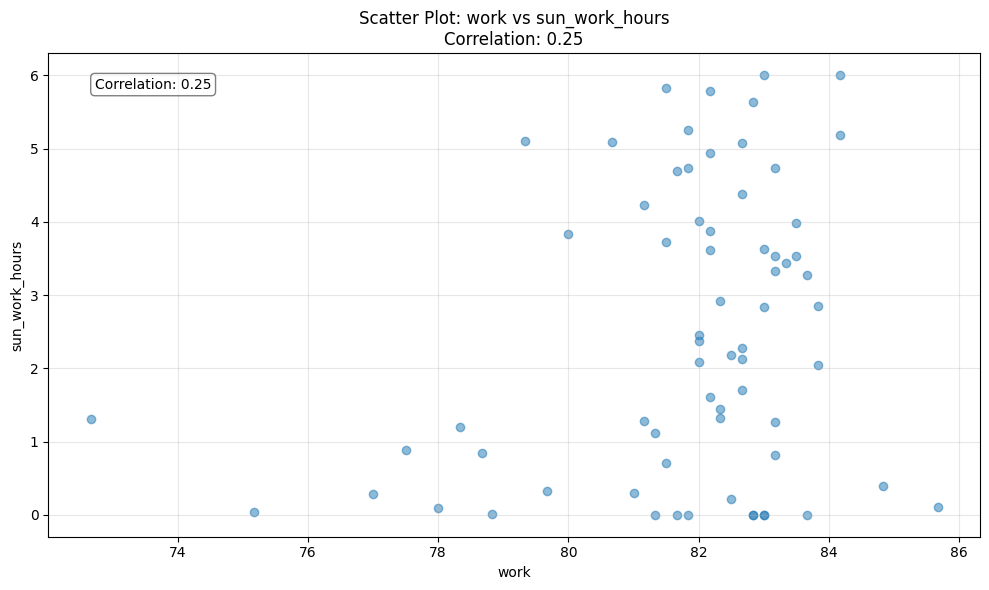

In [48]:
plot_scatter_with_correlation(work_days, 'work', 'sun_work_hours')

In [159]:
from pandas._typing import timedelta

In [49]:
work_days['work']

Date
2024-05-29    78.000000
2024-05-30    84.833333
2024-06-01    78.833333
2024-06-02    77.500000
2024-06-03    79.666667
                ...    
2024-09-04    82.000000
2024-09-06    81.000000
2024-09-08    81.833333
2024-09-09    81.666667
2024-09-10    80.666667
Name: work, Length: 68, dtype: float64

In [50]:
work_days['time_since_start'] = (work_days.index - pd.to_datetime(start_date))

In [145]:
work_days['days_since_start']= work_days['time_since_start'].apply(lambda x: x.total_seconds() / (3600 * 24))

NameError: name 'work_days' is not defined

In [68]:
work_days['time_since_start']

Date
2024-05-29     1 days
2024-05-30     2 days
2024-06-01     4 days
2024-06-02     5 days
2024-06-03     6 days
               ...   
2024-09-04    99 days
2024-09-06   101 days
2024-09-08   103 days
2024-09-09   104 days
2024-09-10   105 days
Name: time_since_start, Length: 68, dtype: timedelta64[ns]

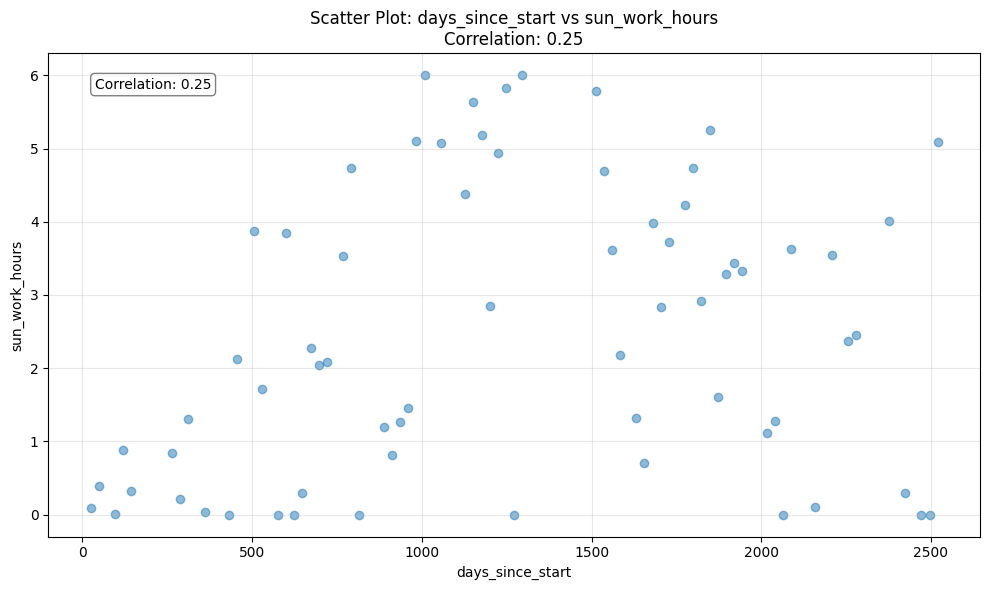

In [69]:
plot_scatter_with_correlation(work_days,'days_since_start', 'sun_work_hours')

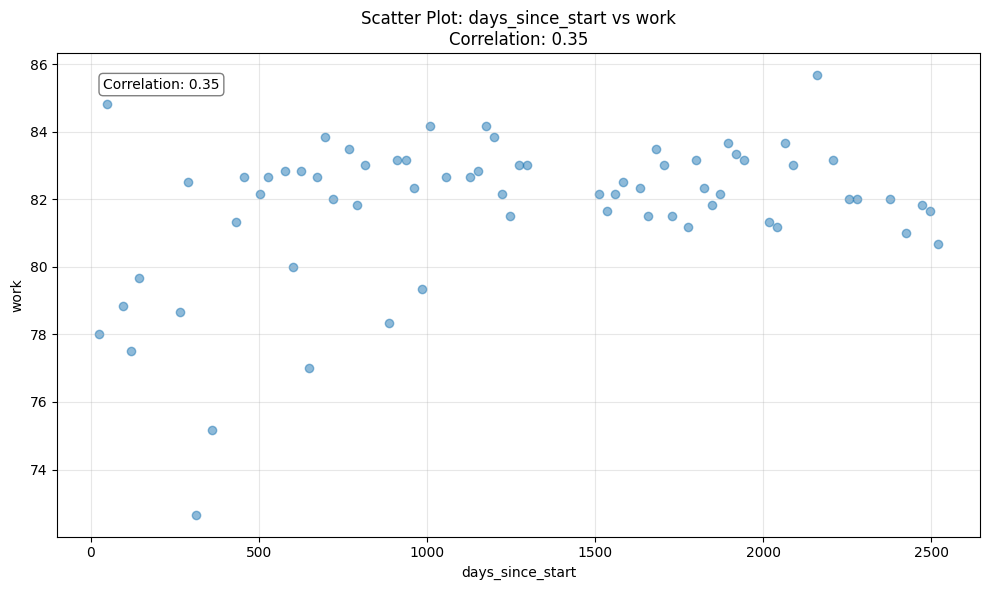

In [78]:
plot_scatter_with_correlation(work_days, 'days_since_start', 'work')

In [71]:
work_days['days_since_start']

Date
2024-05-29      24.0
2024-05-30      48.0
2024-06-01      96.0
2024-06-02     120.0
2024-06-03     144.0
               ...  
2024-09-04    2376.0
2024-09-06    2424.0
2024-09-08    2472.0
2024-09-09    2496.0
2024-09-10    2520.0
Name: days_since_start, Length: 68, dtype: float64

In [73]:
from sklearn.linear_model import LinearRegression

model_work = LinearRegression().fit(work_days[['days_since_start']], work_days[['work']])
model_sun = LinearRegression().fit(work_days[['days_since_start']], work_days[['sun_work_hours']])
model_sun_work = LinearRegression().fit(work_days[['sun_work_hours']], work_days[['work']])
model_sun_time = LinearRegression().fit(work_days[['sun_work_hours']], work_days[['days_since_start']])

# Create new columns with residuals
work_days[['work_residuals']] = work_days[['work']] - model_work.predict(work_days[['days_since_start']])
work_days[['sun_hours_residuals']] = work_days[['sun_work_hours']] - model_sun.predict(work_days[['days_since_start']])
work_days[['work_sun_residual']] = work_days[['work']] - model_sun_work.predict(work_days[['sun_work_hours']])
work_days[['time_sun_residual']] = work_days[['days_since_start']] - model_sun_time.predict(work_days[['sun_work_hours']])



# E = aT + N 
# E - aT = Estimate(N)

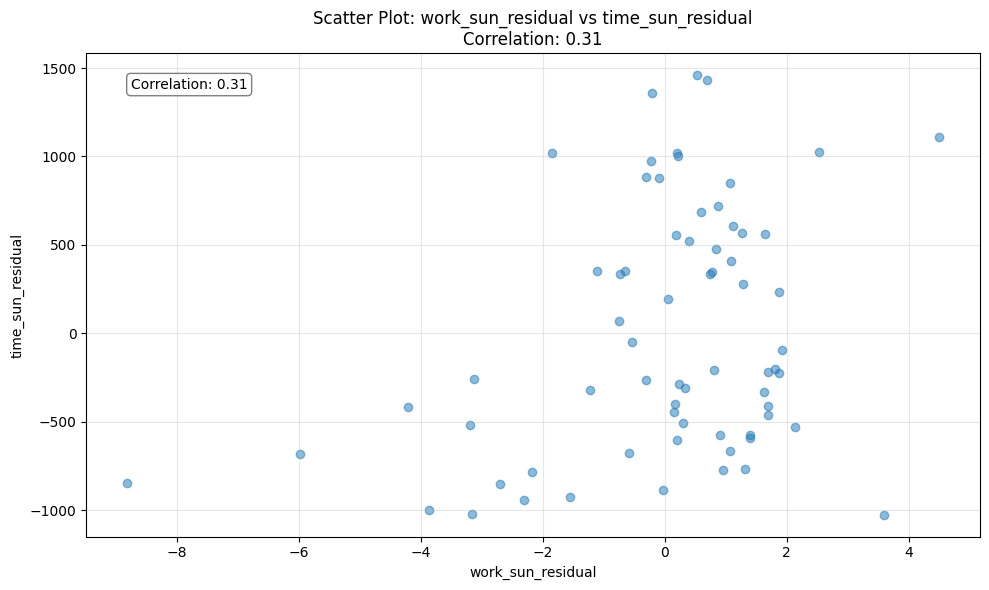

In [74]:
plot_scatter_with_correlation(work_days, 'work_sun_residual', 'time_sun_residual')

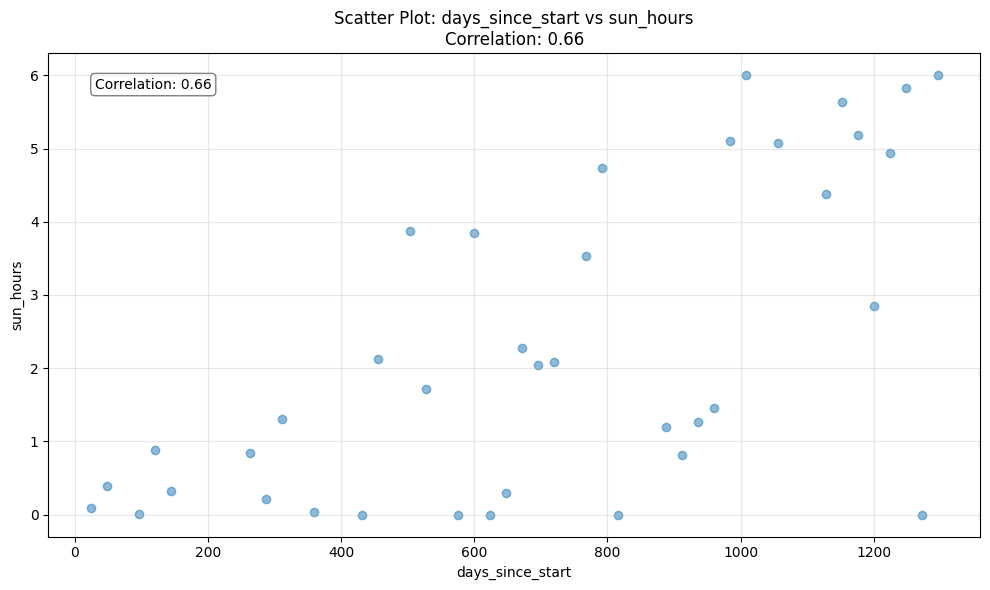

In [75]:
plot_scatter_with_correlation(work_days, 'days_since_start','sun_hours')

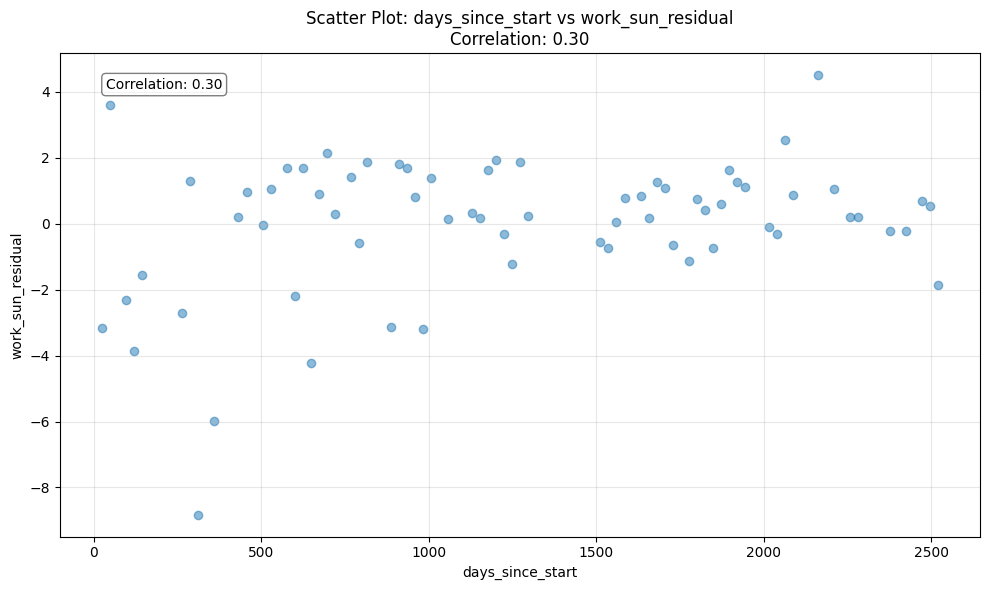

In [76]:
# Sanity check if sun screens off time:
plot_scatter_with_correlation(work_days, 'days_since_start', 'work_sun_residual')

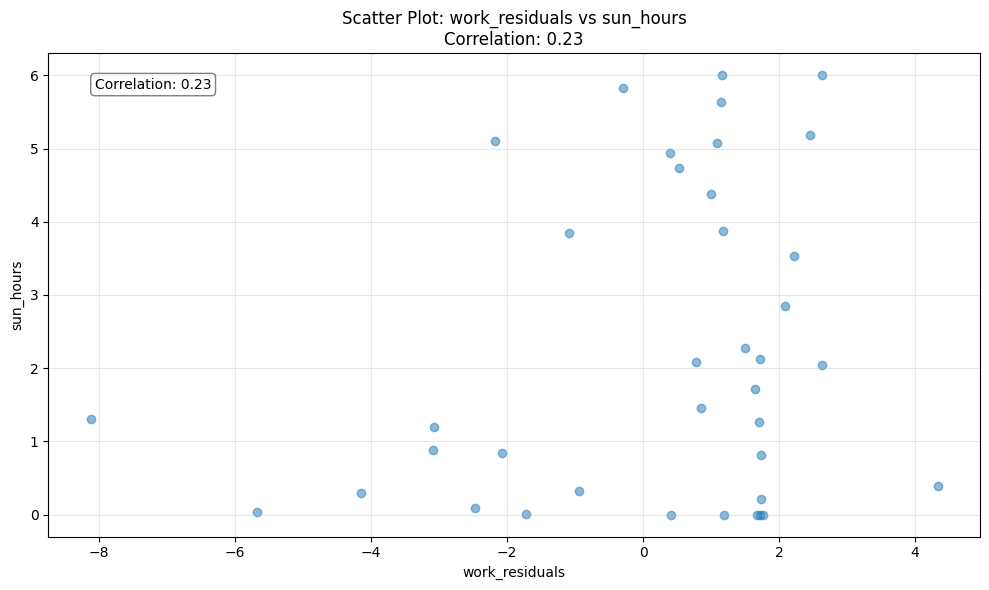

In [77]:
plot_scatter_with_correlation(work_days, 'work_residuals', 'sun_hours')

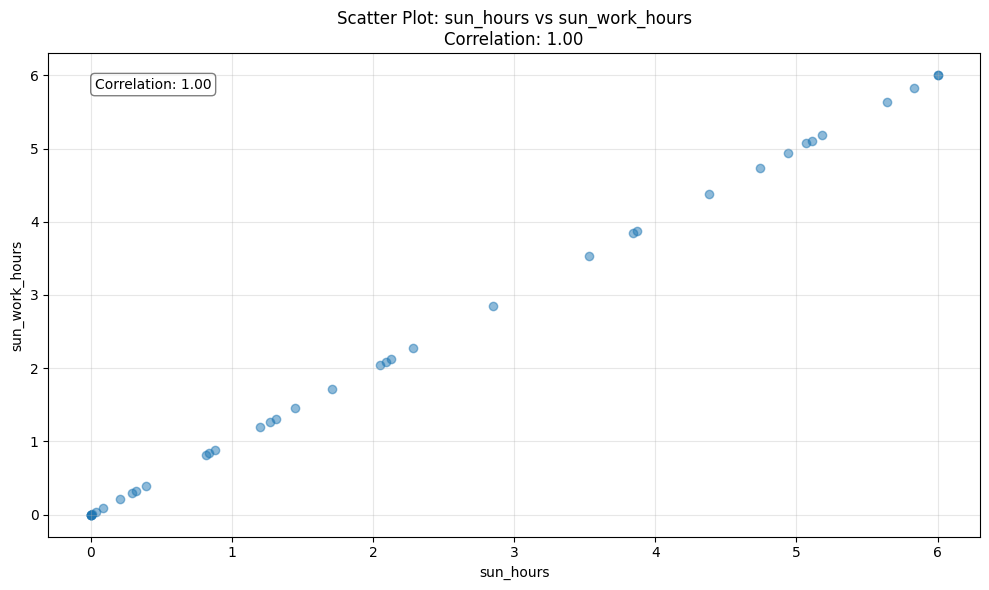

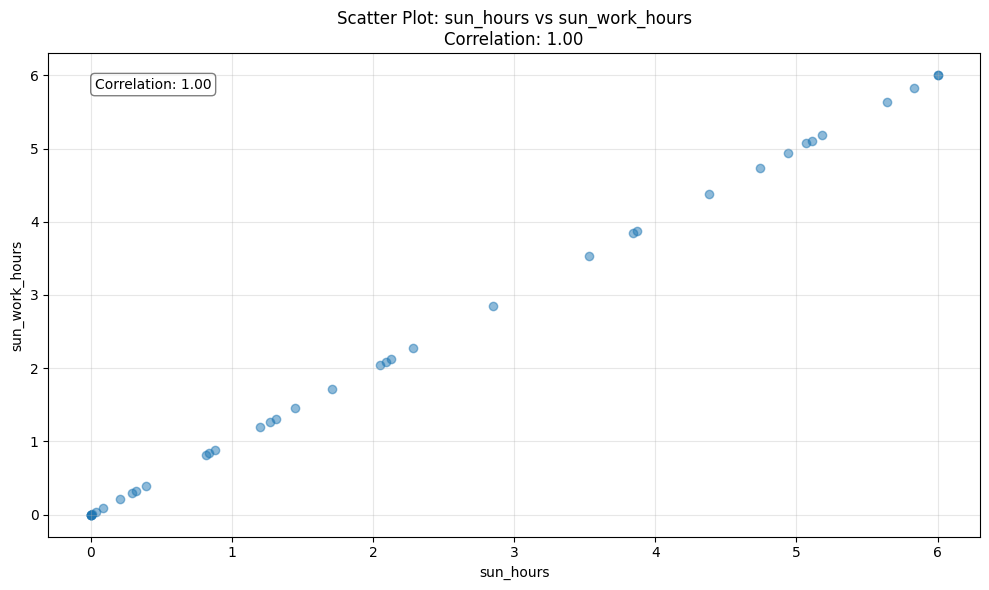

In [180]:
plot_scatter_with_correlation(work_days, 'sun_hours', 'sun_work_hours')